In [47]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import yaml
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
import cddm_data_simulation as cds
import boundary_functions as bf
from datetime import datetime
from statsmodels.distributions.empirical_distribution import ECDF
import scipy as scp

In [17]:
def get_r2_vec(estimates = [0, 0, 0],
               ground_truths = [0, 0, 0]):
    """Function reads in parameter estimates and group truths and returns regression function"""
    r2_vec = []
    for i in range(estimates.shape[1]):
        reg = LinearRegression().fit(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T)
        r2_vec.append(str(round(reg.score(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T), 2)))
    return r2_vec

def hdi_eval(posterior_samples = [],
             ground_truths = []):
    
    vec_dim_1 = posterior_samples.shape[0]
    vec_dim_2 = posterior_samples.shape[2]
    
    vec = np.zeros((vec_dim_1, vec_dim_2))

    for i in range(vec_dim_1):
        for j in range(vec_dim_2):
            my_cdf = ECDF(posterior_samples[i, :, j])
            vec[i,j] = my_cdf(ground_truths[i, j])

        if i % 100 == 0:
            print(i)
  
    # Get calibration statistics
    prop_covered_by_param = []
    for i in range(vec.shape[1]):
        prop_covered_by_param.append(np.sum((vec[:, i] > 0.01) * (vec[:, i] < 0.99)) / vec[:, :].shape[0])
    
    prop_covered_all = (vec[:, 0] > 0.01) * (vec[:, 0] < 0.99)
    for i in range(1, vec.shape[1], 1):
        prop_covered_all = prop_covered_all * (vec[:, i] > 0.01) * (vec[:, i] < 0.99)
    prop_covered_all = np.sum(prop_covered_all) / vec.shape[0]
    
    return vec, prop_covered_by_param, prop_covered_all

def collect_datasets_diff_evo(in_files = [],
                              out_file = [],
                              burn_in = 5000,
                              n_post_samples_by_param = 10000,
                              sort_ = True,
                              save = True):
    """Function prepares raw mcmc data for plotting"""
    
    # Intialization
    in_files = sorted(in_files)
    tmp = pickle.load(open(in_files[0],'rb'))
    n_param_sets = len(in_files) * len(tmp[2])
    n_param_sets_file = len(tmp[2])
    n_chains = tmp[2][0][0].shape[0]
    n_samples = tmp[2][0][0].shape[1]
    n_params = tmp[2][0][0].shape[2]
    
    # Data containers 
    means = np.zeros((n_param_sets, n_params))
    maps = np.zeros((n_param_sets, n_params))
    orig_params = np.zeros((n_param_sets, n_params))
    r_hat_last = np.zeros((n_param_sets))
    posterior_subsamples = np.zeros((n_param_sets, n_post_samples_by_param, n_params))
    posterior_subsamples_ll = np.zeros((n_param_sets, n_post_samples_by_param))

    file_cnt = 0
    for file_ in in_files:
        # Load datafile in
        tmp_data = pickle.load(open(file_, 'rb'))
        for i in range(n_param_sets_file):
            
            # Extract samples and log likelihood sequences
            tmp_samples = np.reshape(tmp_data[2][i][0][:, burn_in:, :], (-1, n_params))
            tmp_log_l = np.reshape(tmp_data[2][i][1][:, burn_in:], (-1))        
            
            # Fill in return datastructures
            posterior_subsamples[(n_param_sets_file * file_cnt) + i, :, :] = tmp_samples[np.random.choice(tmp_samples.shape[0], size = n_post_samples_by_param), :]
            posterior_subsamples_ll[(n_param_sets_file * file_cnt) + i, :] = tmp_log_l[np.random.choice(tmp_log_l.shape[0], size = n_post_samples_by_param)]
            means[(n_param_sets_file * file_cnt) + i, :] = np.mean(tmp_samples, axis = 0)
            maps[(n_param_sets_file * file_cnt) + i, :] = tmp_samples[np.argmax(tmp_log_l), :]
            orig_params[(n_param_sets_file * file_cnt) + i, :] = tmp_data[0][i, :]
            r_hat_last[(n_param_sets_file * file_cnt) + i] = tmp_data[2][i][2][-1]
            
        print(file_cnt)
        file_cnt += 1
    
    out_dict = {'means': means, 'maps': maps, 'gt': orig_params, 'r_hats': r_hat_last, 'posterior_samples': posterior_subsamples, 'posterior_ll': posterior_subsamples_ll}
    if save == True:
        print('writing to file to ' + out_file)
        pickle.dump(out_dict, open(out_file, 'wb'), protocol = 2)
    
    return out_dict

# A of T statistics
def compute_boundary_rmse(mode = 'max_t_global', # max_t_global, max_t_local, quantile
                          boundary_fun = bf.weibull_cdf, # bf.angle etc.
                          parameters_estimated =  [], #mcmc_dict['means'][mcmc_dict['r_hats'] < r_hat_cutoff, :],
                          parameters_true = [], # mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, :],
                          model = 'weibull_cdf',
                          max_t = 20,
                          n_probes = 1000):
    

    parameters_estimated_tup = tuple(map(tuple, parameters_estimated[:, 4:]))
    
    #print(parameters_estimated_tup)
    parameters_true_tup = tuple(map(tuple, parameters_true[:, 4:]))
    t_probes = np.linspace(0, max_t, n_probes)
    bnd_est = np.zeros((len(parameters_estimated), n_probes))
    bnd_true = np.zeros((len(parameters_estimated), n_probes))
    
    # get bound estimates
    for i in range(len(parameters_estimated)):
        #print(parameters_estimated[i])
        if model == 'weibull_cdf':
            bnd_est[i] = np.maximum(parameters_estimated[i, 1] * boundary_fun(*(t_probes, ) + parameters_estimated_tup[i]), 0)
            bnd_true[i] = np.maximum(parameters_true[i, 1] * boundary_fun(*(t_probes, ) + parameters_true_tup[i]), 0)
        if model == 'angle':
            bnd_est[i] = np.maximum(parameters_estimated[i, 1] + boundary_fun(*(t_probes, ) + parameters_estimated_tup[i]), 0)
            bnd_true[i] = np.maximum(parameters_true[i, 1] + boundary_fun(*(t_probes, ) + parameters_true_tup[i]), 0)
            #print(parameters_estimated[i, 1] * boundary_fun(*(t_probes, ) + parameters_estimated_tup[i]))
            #print(bnd_true[i])
        else:
            bnd_est[i] = parameters_estimated[i, 1]
            bnd_true[i] = parameters_estimated[i, 1]
            
#         if i % 100 == 0:
#             print(i)
    # compute rmse
    rmse_vec = np.zeros((len(parameters_estimated_tup)))
    dist_param_euclid = np.zeros((len(parameters_estimated_tup)))
    for i in range(len(parameters_estimated)):
        rmse_vec[i] = np.sqrt(np.sum(np.square(bnd_est[i] - bnd_true[i])) / n_probes)
        dist_param_euclid[i] = np.sqrt(np.sum(np.square(parameters_estimated[i] - parameters_true[i])))
    
    return rmse_vec, dist_param_euclid

In [18]:
# SUPPORT FUNCTIONS GRAPHS
def parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'], 
                            title = 'Parameter Recovery: ABC-NN',
                            ground_truths = [0, 0, 0],
                            estimates = [0, 0, 0],
                            estimate_variances = [0, 0, 0],
                            r2_vec = [0, 0, 0],
                            cols = 3,
                            save = True,
                            model = '', 
                            machine = '',
                            method = 'cnn',
                            data_signature = ''): # color_param 'none' 
    
    grayscale_map = plt.get_cmap('gray')
    
    normalized_sds = np.zeros(estimates.shape)
    for i in range(estimates.shape[1]):
        normalized_sds[:, i] = (estimate_variances[:, i] - np.min(estimate_variances[:, i])) \
        / (np.max(estimate_variances[:, i]) - np.min(estimate_variances[:, i]))

    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, 
                           cols, 
                           figsize = (12, 12), 
                           sharex = False, 
                           sharey = False)
    
    fig.suptitle(title, fontsize = 24)
    sns.despine(right = True)

    for i in range(estimates.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)

        sns.regplot(ground_truths[:, i], estimates[:, i], 
                    color = 'black', 
                    marker =  '.',
                    fit_reg = False,
                    ax = ax[row_tmp, col_tmp],
                    scatter_kws = {'s': 120, 'alpha': 0.5, 'color': grayscale_map(normalized_sds[:, i])})
        unity_coords = np.linspace(*ax[row_tmp, col_tmp].get_xlim())
        ax[row_tmp, col_tmp].plot(unity_coords, unity_coords, color = 'red')
        
        # ax.plot(x, x)

        ax[row_tmp, col_tmp].text(0.7, 0.1, '$R^2$: ' + r2_vec[i], 
                                  transform = ax[row_tmp, col_tmp].transAxes, 
                                  fontsize = 14)
        ax[row_tmp, col_tmp].set_xlabel(ax_titles[i] + ' - ground truth', 
                                        fontsize = 16);
        ax[row_tmp, col_tmp].set_ylabel(ax_titles[i] + ' - posterior mean', 
                                        fontsize = 16);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 14)

    for i in range(estimates.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    
    if save == True:
        if machine == 'home':
            fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/parameter_recovery"
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)
        
        figure_name = 'parameter_recovery_plot_'
        plt.subplots_adjust(top = 0.9)
        plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
        plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '.png', dpi = 300, )
   
    return plt.show()

# SUPPORT FUNCTIONS GRAPHS
def parameter_recovery_hist(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                            estimates = [0, 0, 0],
                            r2_vec = [0, 0, 0],
                            cols = 3,
                            save = True,
                            model = '',
                            machine = '',
                            posterior_stat = 'mean', # can be 'mean' or 'map'
                            data_signature = '',
                            method = 'cnn'): # color_param 'none' 
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, 
                           cols, 
                           figsize = (12, 12), 
                           sharex = False, 
                           sharey = False)
    
    fig.suptitle('Ground truth - Posterior ' + posterior_stat + ': ' + model.upper(), fontsize = 24)
    sns.despine(right = True)

    for i in range(estimates.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)

        sns.distplot(estimates[:, i], 
                     color = 'black',
                     bins = 50,
                     kde = False,
                     rug = True,
                     rug_kws = {'alpha': 0.2, 'color': 'grey'},
                     hist_kws = {'alpha': 1, 'range': (-0.5, 0.5), 'edgecolor': 'black'},
                     ax = ax[row_tmp, col_tmp])
        
        ax[row_tmp, col_tmp].axvline(x = 0, linestyle = '--', color = 'red', label = 'ground truth') # ymin=0, ymax=1)
        ax[row_tmp, col_tmp].axvline(x = np.mean(estimates[:, i]), linestyle = '--', color = 'blue', label = 'mean offset')
        
        ax[row_tmp, col_tmp].set_xlabel(ax_titles[i], 
                                        fontsize = 16);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 14);
        
        if row_tmp == 0 and col_tmp == 0:
            ax[row_tmp, col_tmp].legend(labels = ['ground_truth', 'mean_offset'], fontsize = 14)


    for i in range(estimates.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    
    if save == True:
        if machine == 'home':
            fig_dir = '/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/' + method + '/parameter_recovery'
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)

        figure_name = 'parameter_recovery_hist_'
        plt.subplots_adjust(top = 0.9)
        plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
        plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '.png', dpi = 300)
   
    return plt.show()


def posterior_variance_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'], 
                            posterior_variances = [0, 0, 0],
                            cols = 3,
                            save = True,
                            data_signature = '',
                            model = '',
                            method = 'cnn'):

    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, 
                           cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    
    fig.suptitle('Posterior Variance: ' + model.upper(), fontsize = 40)
    sns.despine(right = True)

    for i in range(posterior_variances.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        sns.distplot(posterior_variances[:, i], 
                     color = 'black',
                     bins = 50,
                     kde = False,
                     rug = True,
                     rug_kws = {'alpha': 0.2, 'color': 'grey'},
                     hist_kws = {'alpha': 1, 'range': (0, 0.2), 'edgecolor': 'black'},
                     ax = ax[row_tmp, col_tmp])
        
        ax[row_tmp, col_tmp].set_xlabel(ax_titles[i], 
                                        fontsize = 24);
        
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24);
        

    for i in range(posterior_variances.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    
    if save == True:
        if machine == 'home':
            fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/posterior_variance"
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)
        
        figure_name = 'posterior_variance_plot_'
        plt.subplots_adjust(top = 0.9)
        plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
        plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '.png', dpi = 300, )
   
    return plt.show()


def hdi_p_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'], 
               p_values = [0, 0, 0],
               cols = 3,
               save = True,
               model = '',
               data_signature = '',
               method = 'cnn'):

    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, 
                           cols, 
                           figsize = (12, 12), 
                           sharex = False, 
                           sharey = False)
    
    fig.suptitle('Bayesian p value of ground truth: ' + model.upper(), fontsize = 24)
    sns.despine(right = True)

    for i in range(p_values.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        sns.distplot(p_values[:, i], 
                     bins = 20,
                     color = 'black',
                     kde = False,
                     rug = False,
                     rug_kws = {'alpha': 0.2, 'color': 'grey'},
                     hist_kws = {'alpha': 1, 'edgecolor': 'black'},
                     ax = ax[row_tmp, col_tmp])
        
        ax[row_tmp, col_tmp].set_xlabel(ax_titles[i], 
                                        fontsize = 16);
        
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 14);

    for i in range(p_values.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    
    if save == True:
        if machine == 'home':
            fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/hdi_p"
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)
                
        figure_name = 'hdi_p_plot_'
        plt.subplots_adjust(top = 0.9)
        plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
        plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '.png', dpi = 300, )
   
    return plt.show()

def hdi_coverage_plot(ax_titles = [],
                      coverage_probabilities = [],
                      save = True,
                      model = '',
                      data_signature = '',
                      method = 'cnn'):
    
    plt.bar(ax_titles, 
            coverage_probabilities,
            color = 'black')
    plt.title( model.upper() + ': Ground truth in HDI?', size = 20)
    plt.xticks(size = 20)
    plt.yticks(np.arange(0, 1, step = 0.2), size = 20)
    plt.ylabel('Prob. HDI covers', size = 20)
    
    if save == True:
        if machine == 'home':
            fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/hdi_coverage"
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)
        
        figure_name = 'hdi_coverage_plot_'
        plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '.png', dpi = 300, )
    
    return plt.show()

def posterior_predictive_plot(ax_titles = [], 
                              title = 'POSTERIOR PREDICTIVES: ',
                              x_labels = [],
                              posterior_samples = [],
                              ground_truths = [],
                              cols = 3,
                              model = 'angle',
                              data_signature = '',
                              n_post_params = 100,
                              samples_by_param = 10,
                              save = False,
                              show = False,
                              machine = 'home',
                              method = 'cnn'):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 1)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (12, 12), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title + model.upper(), fontsize = 24)
    sns.despine(right = True)

    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        post_tmp = np.zeros((n_post_params * samples_by_param, 2))
        idx = np.random.choice(posterior_samples.shape[1], size = n_post_params, replace = False)

        # Run Model simulations for posterior samples
        for j in range(n_post_params):
            if model == 'ddm':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        ndt = posterior_samples[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.001,
                                        max_t = 20, 
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.constant,
                                        boundary_multiplicative = True,
                                        boundary_params = {})
                
            if model == 'full_ddm':
                out = cds.full_ddm(v = posterior_samples[i, idx[j], 0],
                                   a = posterior_samples[i, idx[j], 1],
                                   w = posterior_samples[i, idx[j], 2],
                                   ndt = posterior_samples[i, idx[j], 3],
                                   dw = posterior_samples[i, idx[j], 4],
                                   sdv = posterior_samples[i, idx[j], 5],
                                   dndt = posterior_samples[i, idx[j], 6],
                                   s = 1,
                                   delta_t = 0.001,
                                   max_t = 20,
                                   n_samples = samples_by_param,
                                   print_info = False,
                                   boundary_fun = bf.constant,
                                   boundary_multiplicative = True,
                                   boundary_params = {})

            if model == 'angle':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        ndt = posterior_samples[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.001, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.angle,
                                        boundary_multiplicative = False,
                                        boundary_params = {'theta': posterior_samples[i, idx[j], 4]})
            
            if model == 'weibull_cdf':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        ndt = posterior_samples[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.001, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.weibull_cdf,
                                        boundary_multiplicative = True,
                                        boundary_params = {'alpha': posterior_samples[i, idx[j], 4],
                                                           'beta': posterior_samples[i, idx[j], 5]})
            if model == 'levy':
                out = cds.levy_flexbound(v = posterior_samples[i, idx[j], 0],
                                         a = posterior_samples[i, idx[j], 1],
                                         w = posterior_samples[i, idx[j], 2],
                                         alpha_diff = posterior_samples[i, idx[j], 3],
                                         ndt = posterior_samples[i, idx[j], 4],
                                         s = 1,
                                         delta_t = 0.001,
                                         max_t = 20,
                                         n_samples = samples_by_param,
                                         print_info = False,
                                         boundary_fun = bf.constant,
                                         boundary_multiplicative = True, 
                                         boundary_params = {})
            
            if model == 'ornstein':
                out = cds.ornstein_uhlenbeck(v = posterior_samples[i, idx[j], 0],
                                             a = posterior_samples[i, idx[j], 1],
                                             w = posterior_samples[i, idx[j], 2],
                                             g = posterior_samples[i, idx[j], 3],
                                             ndt = posterior_samples[i, idx[j], 4],
                                             s = 1,
                                             delta_t = 0.001, 
                                             max_t = 20,
                                             n_samples = samples_by_param,
                                             print_info = False,
                                             boundary_fun = bf.constant,
                                             boundary_multiplicative = True,
                                             boundary_params = {})
            if model == 'ddm_sdv':
                out = cds.ddm_sdv(v = posterior_samples[i, idx[j], 0],
                                  a = posterior_samples[i, idx[j], 1],
                                  w = posterior_samples[i, idx[j], 2],
                                  ndt = posterior_samples[i, idx[j], 3],
                                  sdv = posterior_samples[i, idx[j], 4],
                                  s = 1,
                                  delta_t = 0.001,
                                  max_t = 20,
                                  n_samples = samples_by_param,
                                  print_info = False,
                                  boundary_fun = bf.constant,
                                  boundary_multiplicative = True,
                                  boundary_params = {})
            
            post_tmp[(samples_by_param * j):(samples_by_param * (j + 1)), :] = np.concatenate([out[0], out[1]], axis = 1)
        
        # Run Model simulations for true parameters
        if model == 'ddm':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    ndt = ground_truths[i, 3],
                                    s = 1,
                                    delta_t = 0.001,
                                    max_t = 20, 
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.constant,
                                    boundary_multiplicative = True,
                                    boundary_params = {})

        if model == 'full_ddm':
            out = cds.full_ddm(v = ground_truths[i, 0],
                               a = ground_truths[i, 1],
                               w = ground_truths[i, 2],
                               ndt = ground_truths[i, 3],
                               dw = ground_truths[i, 4],
                               sdv = ground_truths[i, 5],
                               dndt = ground_truths[i, 6],
                               s = 1,
                               delta_t = 0.001,
                               max_t = 20,
                               n_samples = 10000,
                               print_info = False,
                               boundary_fun = bf.constant,
                               boundary_multiplicative = True,
                               boundary_params = {})

        if model == 'angle':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    ndt = ground_truths[i, 3],
                                    s = 1,
                                    delta_t = 0.001, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.angle,
                                    boundary_multiplicative = False,
                                    boundary_params = {'theta': ground_truths[i, 4]})

        if model == 'weibull_cdf':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    ndt = ground_truths[i, 3],
                                    s = 1,
                                    delta_t = 0.001, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.weibull_cdf,
                                    boundary_multiplicative = True,
                                    boundary_params = {'alpha': ground_truths[i, 4],
                                                       'beta': ground_truths[i, 5]})
        if model == 'levy':
            out = cds.levy_flexbound(v = ground_truths[i, 0],
                                     a = ground_truths[i, 1],
                                     w = ground_truths[i, 2],
                                     alpha_diff = ground_truths[i, 3],
                                     ndt = ground_truths[i, 4],
                                     s = 1,
                                     delta_t = 0.001,
                                     max_t = 20,
                                     n_samples = 10000,
                                     print_info = False,
                                     boundary_fun = bf.constant,
                                     boundary_multiplicative = True, 
                                     boundary_params = {})

        if model == 'ornstein':
            out = cds.ornstein_uhlenbeck(v = ground_truths[i, 0],
                                         a = ground_truths[i, 1],
                                         w = ground_truths[i, 2],
                                         g = ground_truths[i, 3],
                                         ndt = ground_truths[i, 4],
                                         s = 1,
                                         delta_t = 0.001, 
                                         max_t = 20,
                                         n_samples = 10000,
                                         print_info = False,
                                         boundary_fun = bf.constant,
                                         boundary_multiplicative = True,
                                         boundary_params ={})
            
        if model == 'ddm_sdv':
            out = cds.ddm_sdv(v = ground_truths[i, 0],
                              a = ground_truths[i, 1],
                              w = ground_truths[i, 2],
                              ndt = ground_truths[i, 3],
                              sdv = ground_truths[i, 4],
                              s = 1,
                              delta_t = 0.001,
                              max_t = 20,
                              n_samples = samples_by_param,
                              print_info = False,
                              boundary_fun = bf.constant,
                              boundary_multiplicative = True,
                              boundary_params = {})
        
        gt_tmp = np.concatenate([out[0], out[1]], axis = 1)
        print('passed through')
            
        sns.distplot(post_tmp[:, 0] * post_tmp[:, 1], 
                     bins = 50, 
                     kde = False, 
                     rug = False, 
                     hist_kws = {'alpha': 1, 'color': 'black', 'fill': 'black', 'density': 1, 'edgecolor': 'black'},
                     ax = ax[row_tmp, col_tmp]);
        sns.distplot(gt_tmp[:, 0] * gt_tmp[:, 1], 
                     hist_kws = {'alpha': 0.5, 'color': 'grey', 'fill': 'grey', 'density': 1, 'edgecolor': 'grey'}, 
                     bins = 50, 
                     kde = False, 
                     rug = False,
                     ax = ax[row_tmp, col_tmp])
        
        
        if row_tmp == 0 and col_tmp == 0:
            ax[row_tmp, col_tmp].legend(labels = [model, 'posterior'], 
                                        fontsize = 12, loc = 'upper right')
        
        if row_tmp == (rows - 1):
            ax[row_tmp, col_tmp].set_xlabel('RT', 
                                            fontsize = 14);
        
        if col_tmp == 0:
            ax[row_tmp, col_tmp].set_ylabel('Density', 
                                            fontsize = 14);
        
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 16)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 12)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 12)
        
    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    if save == True:
        if machine == 'home':
            fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/posterior_predictive"
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)
                
        figure_name = 'posterior_predictive_'
        #plt.tight_layout()
        plt.subplots_adjust(top = 0.9)
        plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
        plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '.png', dpi = 300) #  bbox_inches = 'tight')
    
    if show:
        return plt.show()

  
# Plot bound
# Mean posterior predictives
def boundary_posterior_plot(ax_titles = ['hi-hi', 'hi-lo', 'hi-mid', 'lo-hi', 'lo-mid'], 
                            title = 'Model uncertainty plot: ',
                            posterior_samples = [],
                            ground_truths = [],
                            cols = 3,
                            model = 'weibull_cdf',
                            data_signature = '',
                            n_post_params = 500,
                            samples_by_param = 10,
                            max_t = 2,
                            show = True,
                            save = False,
                            machine = 'home',
                            method = 'cnn'):
    
    rows = int(np.ceil(len(ax_titles) / cols))
    sub_idx = np.random.choice(posterior_samples.shape[1], size = n_post_params)
    posterior_samples = posterior_samples[:, sub_idx, :]
    
    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True,
            font_scale = 2)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    
    my_suptitle = fig.suptitle(title + model, fontsize = 40)
    sns.despine(right = True)
    
    t_s = np.arange(0, max_t, 0.01)
    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        
        idx = np.random.choice(posterior_samples.shape[1], size = n_post_params, replace = False)

        ax[row_tmp, col_tmp].set_xlim(0, max_t)
        ax[row_tmp, col_tmp].set_ylim(-2, 2)
        
        # Run simulations and add histograms
        # True params
        if model == 'angle':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    ndt = ground_truths[i, 3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.angle,
                                    boundary_multiplicative = False,
                                    boundary_params = {'theta': ground_truths[i, 4]})
            
        if model == 'weibull_cdf':
            out = cds.ddm_flexbound(v = ground_truths[i, 0],
                                    a = ground_truths[i, 1],
                                    w = ground_truths[i, 2],
                                    ndt = ground_truths[i, 3],
                                    s = 1,
                                    delta_t = 0.01, 
                                    max_t = 20,
                                    n_samples = 10000,
                                    print_info = False,
                                    boundary_fun = bf.weibull_cdf,
                                    boundary_multiplicative = True,
                                    boundary_params = {'alpha': ground_truths[i, 4],
                                                       'beta': ground_truths[i, 5]})
        tmp_true = np.concatenate([out[0], out[1]], axis = 1)
        choice_p_up_true = np.sum(tmp_true[:, 1] == 1) / tmp_true.shape[0]
        
        # Run Model simulations for posterior samples
        tmp_post = np.zeros((n_post_params*samples_by_param, 2))
        for j in range(n_post_params):
            if model == 'angle':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        ndt = posterior_samples[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.angle,
                                        boundary_multiplicative = False,
                                        boundary_params = {'theta': posterior_samples[i, idx[j], 4]})
            
            if model == 'weibull_cdf':
                out = cds.ddm_flexbound(v = posterior_samples[i, idx[j], 0],
                                        a = posterior_samples[i, idx[j], 1],
                                        w = posterior_samples[i, idx[j], 2],
                                        ndt = posterior_samples[i, idx[j], 3],
                                        s = 1,
                                        delta_t = 0.01, 
                                        max_t = 20,
                                        n_samples = samples_by_param,
                                        print_info = False,
                                        boundary_fun = bf.weibull_cdf,
                                        boundary_multiplicative = True,
                                        boundary_params = {'alpha': posterior_samples[i, idx[j], 4],
                                                           'beta': posterior_samples[i, idx[j], 5]})
            
            tmp_post[(10 * j):(10 * (j + 1)), :] = np.concatenate([out[0], out[1]], axis = 1)
        
        choice_p_up_post = np.sum(tmp_post[:, 1] == 1) / tmp_post.shape[0]
        
        #ax.set_ylim(-4, 2)
        ax_tmp = ax[row_tmp, col_tmp].twinx()
        ax_tmp.set_ylim(-2, 2)
        ax_tmp.set_yticks([])
        
        counts, bins = np.histogram(tmp_post[tmp_post[:, 1] == 1, 0],
                                bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_post[tmp_post[:, 1] == 1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = choice_p_up_post * counts_2,
                    alpha = 0.2, 
                    color = 'black',
                    edgecolor = 'none',
                    zorder = -1)
        
        counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == 1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = choice_p_up_true * counts_2,
                    alpha = 0.2, 
                    color = 'red',
                    edgecolor = 'none',
                    zorder = -1)
        
             
        #ax.invert_xaxis()
        ax_tmp = ax[row_tmp, col_tmp].twinx()
        ax_tmp.set_ylim(2, -2)
        ax_tmp.set_yticks([])
        
        counts, bins = np.histogram(tmp_post[tmp_post[:, 1] == -1, 0],
                        bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_post[tmp_post[:, 1] == -1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = (1 - choice_p_up_post) * counts_2,
                    alpha = 0.2, 
                    color = 'black',
                    edgecolor = 'none',
                    zorder = -1)
        
        counts, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                bins = np.linspace(0, 10, 100))
    
        counts_2, bins = np.histogram(tmp_true[tmp_true[:, 1] == -1, 0],
                                      bins = np.linspace(0, 10, 100),
                                      density = True)
        ax_tmp.hist(bins[:-1], 
                    bins, 
                    weights = (1 - choice_p_up_true) * counts_2,
                    alpha = 0.2, 
                    color = 'red',
                    edgecolor = 'none',
                    zorder = -1)
        
        # Plot posterior samples 
        for j in range(n_post_params):
            if model == 'weibull_cdf':
                b = posterior_samples[i, idx[i], 1] * bf.weibull_cdf(t = t_s, 
                                                                        alpha = posterior_samples[i, idx[j], 4],
                                                                        beta = posterior_samples[i, idx[j], 5])
            if model == 'angle':
                b = np.maximum(posterior_samples[i, idx[i], 1] + bf.angle(t = t_s, 
                                                                             theta = posterior_samples[i, idx[j], 4]), 0)
            
            start_point_tmp = - posterior_samples[i, idx[j], 1] + \
                              (2 * posterior_samples[i, idx[j], 1] * posterior_samples[i, idx[j], 2])
            slope_tmp = posterior_samples[i, idx[j], 0]
            
            ax[row_tmp, col_tmp].plot(t_s + posterior_samples[i, idx[j], 3], b, 'black',
                                      t_s + posterior_samples[i, idx[j], 3], -b, 'black', 
                                      alpha = 0.05,
                                      zorder = 1000)
            
            for m in range(len(t_s)):
                if (start_point_tmp + (slope_tmp * t_s[m])) > b[m] or (start_point_tmp + (slope_tmp * t_s[m])) < -b[m]:
                    maxid = m
                    break
                maxid = m
            
            ax[row_tmp, col_tmp].plot(t_s[:maxid] + posterior_samples[i, idx[j], 3],
                                      start_point_tmp + slope_tmp * t_s[:maxid], 
                                      'black', 
                                      alpha = 0.05,
                                      zorder = 1000)
            
        # Plot true ground_truths  
        if model == 'weibull_cdf':
            b = ground_truths[i, 1] * bf.weibull_cdf(t = t_s, 
                                            alpha = ground_truths[i, 4],
                                            beta = ground_truths[i, 5])
        if model == 'angle':
            b = np.maximum(ground_truths[i, 1] + bf.angle(t = t_s, theta = ground_truths[i, 4]), 0)

        start_point_tmp = - ground_truths[i, 1] + \
                          (2 * ground_truths[i, 1] * ground_truths[i, 2])
        slope_tmp = ground_truths[i, 0]

        ax[row_tmp, col_tmp].plot(t_s + ground_truths[i, 3], b, 'red', 
                                  t_s + ground_truths[i, 3], -b, 'red', 
                                  alpha = 1,
                                  linewidth = 3,
                                  zorder = 1000)
        
        for m in range(len(t_s)):
            if (start_point_tmp + (slope_tmp * t_s[m])) > b[m] or (start_point_tmp + (slope_tmp * t_s[m])) < -b[m]:
                maxid = m
                break
            maxid = m
        
        print('maxid', maxid)
        ax[row_tmp, col_tmp].plot(t_s[:maxid] + ground_truths[i, 3], 
                                  start_point_tmp + slope_tmp * t_s[:maxid], 
                                  'red', 
                                  alpha = 1, 
                                  linewidth = 3, 
                                  zorder = 1000)
        
        ax[row_tmp, col_tmp].set_zorder(ax_tmp.get_zorder() + 1)
        ax[row_tmp, col_tmp].patch.set_visible(False)
        print('passed through')
        
        #ax[row_tmp, col_tmp].legend(labels = [model, 'bg_stn'], fontsize = 20)
        if row_tmp == rows:
            ax[row_tmp, col_tmp].set_xlabel('rt', 
                                            fontsize = 20);
        ax[row_tmp, col_tmp].set_ylabel('', 
                                        fontsize = 20);
        ax[row_tmp, col_tmp].set_title(ax_titles[i],
                                       fontsize = 20)
        ax[row_tmp, col_tmp].tick_params(axis = 'y', size = 20)
        ax[row_tmp, col_tmp].tick_params(axis = 'x', size = 20)
        
    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')
    
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    if save:
        if machine == 'home':
            fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/model_uncertainty"
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)
                
        figure_name = 'model_uncertainty_plot_'
        plt.savefig(fig_dir + '/' + figure_name + model + data_signature + '.png',
                    dpi = 150, 
                    transparent = False,
                    bbox_inches = 'tight',
                    bbox_extra_artists = [my_suptitle])
    if show:
        return plt.show()
    
def make_posterior_pair_grid(posterior_samples = [],
                             height = 10,
                             aspect = 1,
                             n_subsample = 1000,
                             title = "Posterior Pairwise: ",
                             data_signature = '',
                             gt_available = False,
                             gt = [],
                             save = True,
                             model = None,
                             machine = 'home',
                             method = 'cnn'):
    
    g = sns.PairGrid(posterior_samples.sample(n_subsample), 
                     height = height / len(list(posterior_samples.keys())),
                     aspect = 1,
                     diag_sharey = False)
    g = g.map_diag(sns.kdeplot, color = 'black', shade = True) # shade = True, 
    g = g.map_lower(sns.kdeplot, 
                    shade_lowest = False,
                    n_levels = 30,
                    shade = True, 
                    cmap = 'Greys')
    g = g.map_lower(sns.regplot,
                    color = 'grey',
                    lowess = False,
                    x_ci = None,
                    marker = None,
                    scatter = False,
                    line_kws = {'alpha': 0.5})
    g = g.map_upper(sns.regplot,
                    scatter = True,
                    fit_reg = False,
                    color = 'grey',
                    scatter_kws = {'alpha': 0.01})

    #  g = g.map_upper(sns.scatterplot)
    #  g = g.map_upper(corrdot)
    #  g = g.map_upper(corrfunc)

    [plt.setp(ax.get_xticklabels(), rotation = 45) for ax in g.axes.flat]
    print(g.axes)
    my_suptitle = g.fig.suptitle(title + model.upper() + data_signature, y = 1.03, fontsize = 24)
    
    # If ground truth is available add it in:
    if gt_available:
        for i in range(g.axes.shape[0]):
            for j in range(i + 1, g.axes.shape[0], 1):
                g.axes[i,j].plot(gt[j], gt[i], '.', color = 'red')

        for i in range(g.axes.shape[0]):
            g.axes[i,i].plot(gt[i], g.axes[i,i].get_ylim()[0], '.', color = 'red')

    
    if save == True:
        if machine == 'home':
            fig_dir = "/users/afengler/OneDrive/git_repos/nn_likelihoods/figures/" + method + "/posterior_covariance"
            if not os.path.isdir(fig_dir):
                os.mkdir(fig_dir)
                
        plt.savefig(fig_dir + '/' + 'cov_' + model + data_signature + '.png', 
                    dpi = 300, 
                    transparent = False,
                    bbox_inches = 'tight',
                    bbox_extra_artists = [my_suptitle])
    # Show
    return plt.show()

In [19]:
# # REMAINING META

# ax_titles = {}
# param_lims = {}
# # DDM
# ax_titles['ddm'] = ['v', 'a', 'w', 'ndt']
# param_lims['ddm'] = [(-1.9, 1.9), (0.4, 1.9), (0.25, 0.75), (0.1, 1.9)]

# # DDM Angle
# ax_titles['angle'] = ['v', 'a', 'w', 'ndt', 'angle']
# param_lims['angle'] = [(-1.9, 1.9), (0.4, 1.9), (0.25,0.75), (0.1, 1.9), (0, 1.2)]

# # WEIBULL 
# ax_titles['weibull'] = ['v', 'a', 'w', 'ndt', 'alpha', 'beta']
# param_lims_weibull = [(-1.9, 1.9), (0.4, 1.9), (0.25, 0.75), (0.1, 1.9)]

# # ORNSTEIN
# ax_titles['ornstein'] = ['v', 'a', 'w', 'g', 'ndt']
# param_lims_ornstein = [(-1.9, 1.9), (0.4, 1.9), (0.25, 0.75), (-0.9, 0.9), (0.1, 1.9)]

# # FULL_DDM
# ax_titles_full_ddm = ["v", "a", "w", "ndt", "dw", "sdv", "dndt"]
# param_lims_full_ddm = [(-1.9, 1.9), (0.4, 1.9), (0.25, 0.65), (0.3, 2.2), (0.05, 0.35), (0.05, 0.45), (0.05, 0.2)]

# # LEVY
# ax_titles_levy = ["v", 'a', 'w', 'alpha_diff', 'ndt']
# param_lims_full_ddm = [(-1.9, 1.9), (0.4, 2), (0.3, 0.7), (1.1, 1.9), (0.1, 1.9)]

In [208]:
# Folder data 
model = 'ddm_sdv'
machine = 'home'
method = 'mlp'
n = 4096
r_hat_cutoff = 1.1
now = datetime.now().strftime("%m_%d_%Y")
network_idx = 2
network_type = 'navarro'  # 'mlp', 'cnn', 'navarro'
train_dat = 'analytic'

# Get model metadata
info = pickle.load(open('kde_stats.pickle', 'rb'))
ax_titles = info[model]['param_names'] + info[model]['boundary_param_names']
param_lims = info[model]['param_bounds_network'] + info[model]['boundary_param_bounds_network']

if network_type != 'navarro':
    with open("model_paths.yaml") as tmp_file:
        if network_idx == -1:
            network_path = yaml.load(tmp_file)[model]
            network_id = network_path[list(re.finditer('/', network_path))[-2].end():]
        else:
            if train_dat == 'analytic':
                network_path = yaml.load(tmp_file)[model + '_analytic' + '_batch'][network_idx]
            else:
                network_path = yaml.load(tmp_file)[model + '_batch'][network_idx]
            
            network_id = network_path[list(re.finditer('/', network_path))[-2].end():]
        

    method_comparison_folder = '/Users/afengler/OneDrive/project_nn_likelihoods/data/' + train_dat + '/' + model + '/method_comparison/' + network_id + '/'

else:
    method_comparison_folder = '/Users/afengler/OneDrive/project_nn_likelihoods/data/analytic/' + model + '/method_comparison/' + '/analytic/'


#data_signature_noidx = '_n_' str(n) + '_' + now.strftime("%m_%d_%Y")
#data_signature_idx = '_n_' str(n) + '_' + now.strftime("%m_%d_%Y")


# Get trained networks for model
file_signature = 'post_samp_data_param_recov_unif_reps_1_n_' + str(n) + '_init_mle_1_'
summary_file = method_comparison_folder + 'summary_' + file_signature[:-1] + '.pickle'

# Read in summary file
mcmc_dict = pickle.load(open(summary_file, 'rb'))


# Filter out severe boundary cases
cnt = 0
adj_size = 0.1
for param_bnd_tmp in param_lims:
    if ax_titles[cnt] == 'ndt':
        cnt += 1
    else:
        if cnt == 0:
            bool_vec = ( mcmc_dict['means'][:, cnt] > param_bnd_tmp[1] - 0.1 ) + ( mcmc_dict['means'][:, cnt] < param_bnd_tmp[0] + 0.1 ) 
            cnt += 1
        else:
            bool_vec = (bool_vec + (( mcmc_dict['means'][:, cnt] > param_bnd_tmp[1] - 0.1 ) + ( mcmc_dict['means'][:, cnt] < param_bnd_tmp[0] + 0.1 ))) > 0
            cnt += 1
    print(np.sum(1 - bool_vec))
print(np.sum(1 - bool_vec))

ok_ids = (1 - bool_vec) > 0

for tmp_key in mcmc_dict.keys():
    mcmc_dict[tmp_key] = mcmc_dict[tmp_key][ok_ids]



mcmc_dict['sds'] = np.std(mcmc_dict['posterior_samples'][:, :, :], axis = 1)
mcmc_dict['sds_mean_in_row'] = np.min(mcmc_dict['sds'], axis = 1)
mcmc_dict['gt_cdf_score'], mcmc_dict['p_covered_by_param'], mcmc_dict['p_covered_all'] = hdi_eval(posterior_samples = mcmc_dict['posterior_samples'],
                                                                                                  ground_truths = mcmc_dict['gt'])

# Get regression coefficients on mcmc_dict 
mcmc_dict['r2_means'] = get_r2_vec(estimates = mcmc_dict['means'], 
                          ground_truths = mcmc_dict['gt'])

mcmc_dict['r2_maps'] = get_r2_vec(estimates = mcmc_dict['maps'], 
                          ground_truths = mcmc_dict['gt'])

#mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, :]

mcmc_dict['boundary_rmse'], mcmc_dict['boundary_dist_param_euclid'] = compute_boundary_rmse(mode = 'max_t_global',
                                                                                            boundary_fun = bf.weibull_cdf,
                                                                                            parameters_estimated = mcmc_dict['means'],
                                                                                            parameters_true = mcmc_dict['gt'],
                                                                                            model = model,
                                                                                            max_t = 20,
                                                                                            n_probes = 1000)

mcmc_dict['euc_dist_means_gt'] = np.linalg.norm(mcmc_dict['means'] - mcmc_dict['gt'], axis = 1)
mcmc_dict['euc_dist_maps_gt'] = np.linalg.norm(mcmc_dict['maps'] - mcmc_dict['gt'], axis = 1)
mcmc_dict['euc_dist_means_gt_sorted_id'] = np.argsort(mcmc_dict['euc_dist_means_gt'])
mcmc_dict['euc_dist_maps_gt_sorted_id'] = np.argsort(mcmc_dict['euc_dist_maps_gt'])
mcmc_dict['boundary_rmse_sorted_id'] = np.argsort(mcmc_dict['boundary_rmse'])
mcmc_dict['method'] = method

# sorted_idx_rmse = np.argsort(mcmc_dict['boundary_rmse'])
# bottom_idx_rmse = sorted_idx_rmse[:10]
# middle_idx_rmse = sorted_idx_rmse[int(sorted_idx_rmse.shape[0] / 2) - 5: int(sorted_idx_rmse.shape[0] / 2) + 5]
# top_idx_rmse = sorted_idx_rmse[-10:]

# sorted_idx_map = np.argsort(mcmc_dict['euc_dist_maps_gt'])
# bottom_idx_map = sorted_idx_map[:10]
# middle_idx_map = sorted_idx_map[int(sorted_idx_map.shape[0] / 2) - 5: int(sorted_idx_map.shape[0] / 2) + 5]
# top_idx_map = sorted_idx_map[-10:]

# sorted_idx_mean = np.argsort(mcmc_dict['euc_dist_means_gt'])
# bottom_idx_mean = sorted_idx_mean[:10]
# middle_idx_mean = sorted_idx_mean[int(sorted_idx_mean.shape[0] / 2) - 5: int(sorted_idx_mean.shape[0] / 2) + 5]
# top_idx_mean = sorted_idx_mean[-10:]

1000
1000
862
862
862
862
0
100
200
300
400
500
600
700
800


In [79]:
# Folder data CNN
model = 'angle2'
machine = 'home'
method = 'mlp'
n = 1024
r_hat_cutoff = 1.1
now = datetime.now().strftime("%m_%d_%Y")
network_idx = -1
network_type = 'mlp'  # 'mlp', 'cnn', 'navarro'
train_dat = 'kde'

# Get model metadata
info = pickle.load(open('kde_stats.pickle', 'rb'))
ax_titles = info[model]['param_names'] + info[model]['boundary_param_names']
param_lims = info[model]['param_bounds_sampler'] + info[model]['boundary_param_bounds_sampler']
is_folder = '/users/afengler/OneDrive/project_nn_likelihoods/cogsci/'

# Get trained networks for model
if model == 'weibull_cdf':
    summary_file = is_folder + 'IS_summary_' + 'weibull' + '_' + 'N' + '_' + str(n) + '.pickle'
else:
    summary_file = is_folder + 'IS_summary_' + model + '_' + 'N' + '_' + str(n) + '.pickle'


# Read in summary file
mcmc_dict = pickle.load(open(summary_file, 'rb'))
mcmc_dict['sds'] = np.std(mcmc_dict['posterior_samples'][:, :, :], axis = 1)
mcmc_dict['means'] = np.mean(mcmc_dict['posterior_samples'], axis = 1)
mcmc_dict['gt_cdf_score'], mcmc_dict['p_covered_by_param'], mcmc_dict['p_covered_all'] = hdi_eval(posterior_samples = mcmc_dict['posterior_samples'],
                                                                                                  ground_truths = mcmc_dict['gt'])

# Get regression coefficients on mcmc_dict 
mcmc_dict['r2_means'] = get_r2_vec(estimates = mcmc_dict['means'], 
                                   ground_truths = mcmc_dict['gt'])

# mcmc_dict['r2_maps'] = get_r2_vec(estimates = mcmc_dict['maps'], 
#                           ground_truths = mcmc_dict['gt'])

#mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, :]

mcmc_dict['boundary_rmse'], mcmc_dict['boundary_dist_param_euclid'] = compute_boundary_rmse(mode = 'max_t_global',
                                                                                            boundary_fun = bf.weibull_cdf,
                                                                                            parameters_estimated = mcmc_dict['means'],
                                                                                            parameters_true = mcmc_dict['gt'],
                                                                                            model = model,
                                                                                            max_t = 20,
                                                                                            n_probes = 1000)

mcmc_dict['euc_dist_means_gt'] = np.linalg.norm(mcmc_dict['means'] - mcmc_dict['gt'], axis = 1)
mcmc_dict['euc_dist_means_gt_sorted_id'] = np.argsort(mcmc_dict['euc_dist_means_gt'])
mcmc_dict['boundary_rmse_sorted_id'] = np.argsort(mcmc_dict['boundary_rmse'])
mcmc_dict['method'] = method

# sorted_idx_rmse = np.argsort(mcmc_dict['boundary_rmse'])
# bottom_idx_rmse = sorted_idx_rmse[:10]
# middle_idx_rmse = sorted_idx_rmse[int(sorted_idx_rmse.shape[0] / 2) - 5: int(sorted_idx_rmse.shape[0] / 2) + 5]
# top_idx_rmse = sorted_idx_rmse[-10:]

# sorted_idx_map = np.argsort(mcmc_dict['euc_dist_maps_gt'])
# bottom_idx_map = sorted_idx_map[:10]
# middle_idx_map = sorted_idx_map[int(sorted_idx_map.shape[0] / 2) - 5: int(sorted_idx_map.shape[0] / 2) + 5]
# top_idx_map = sorted_idx_map[-10:]

# sorted_idx_mean = np.argsort(mcmc_dict['euc_dist_means_gt'])
# bottom_idx_mean = sorted_idx_mean[:10]
# middle_idx_mean = sorted_idx_mean[int(sorted_idx_mean.shape[0] / 2) - 5: int(sorted_idx_mean.shape[0] / 2) + 5]
# top_idx_mean = sorted_idx_mean[-10:]

FileNotFoundError: [Errno 2] No such file or directory: '/users/afengler/OneDrive/project_nn_likelihoods/cogsci/IS_summary_angle2_N_4096.pickle'

In [49]:
scp.stats.iqr(np.var(mcmc_dict['posterior_samples'], axis = 1), axis = 0)

array([0.01211537, 0.00337022, 0.00017301, 0.00021529, 0.00138295])

In [50]:
np.mean(np.var(mcmc_dict['posterior_samples'], axis = 1), axis = 0)

array([0.01565947, 0.00420637, 0.0003439 , 0.00024382, 0.00226355])

In [22]:
mcmc_dict['means'] = np.mean(mcmc_dict['posterior_samples'], axis = 1)

In [13]:
my_tmp_files = os.listdir('/Users/afengler/OneDrive/project_nn_likelihoods/cogsci/')
for file_ in my_tmp_files:
    if 'summary' in file_:
        print(file_)

IS_summary_race_model_6_N_1024.pickle
IS_summary_ddm_seq2_N_1024.pickle
IS_summary_ddm_par2_N_1024.pickle
IS_summary_ornstein_N_1024.pickle
IS_summary_ddm_mic2_N_1024.pickle
IS_summary_race_model_4_N_1024.pickle
IS_summary_full_ddm_N_1024.pickle
IS_summary_weibull_N_1024.pickle


In [21]:
mcmc_dict.keys()

dict_keys(['means', 'maps', 'gt', 'r_hats', 'posterior_samples', 'posterior_ll', 'sds', 'gt_cdf_score', 'p_covered_by_param', 'p_covered_all', 'r2_means', 'r2_maps', 'boundary_rmse', 'boundary_dist_param_euclid', 'euc_dist_means_gt', 'euc_dist_maps_gt', 'euc_dist_means_gt_sorted_id', 'euc_dist_maps_gt_sorted_id', 'boundary_rmse_sorted_id', 'method'])

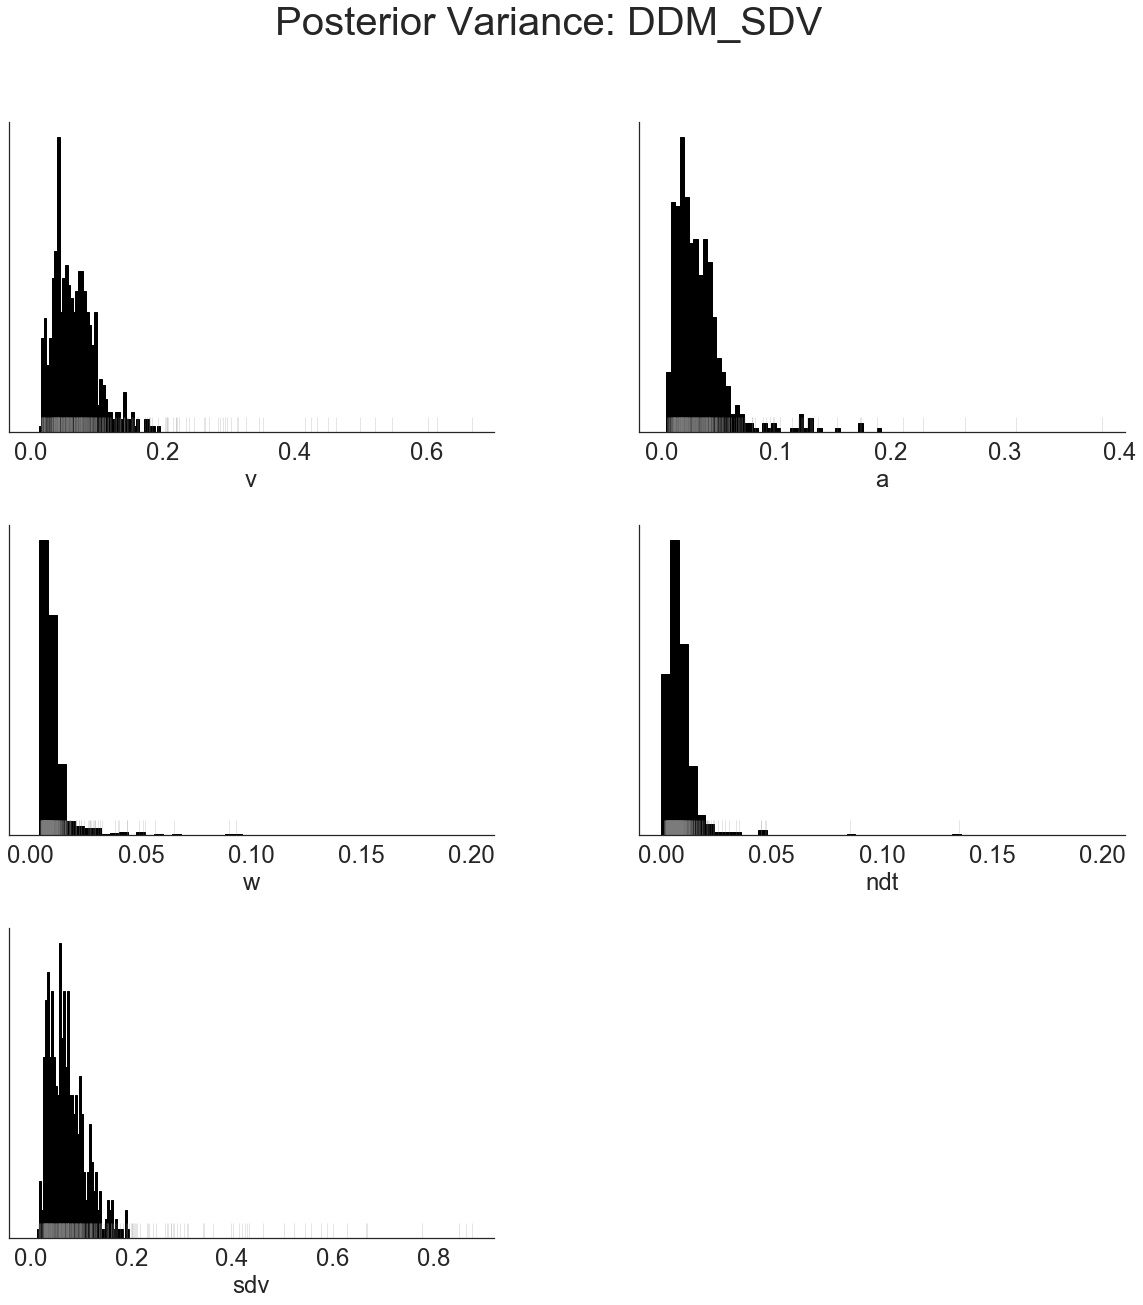

In [200]:
# Posterior variance plot MLP
posterior_variance_plot(ax_titles = ax_titles, 
                        posterior_variances = mcmc_dict['sds'][mcmc_dict['r_hats'] < r_hat_cutoff, :],
                        cols = 2,
                        save = True,
                        data_signature = '_n_' + str(n) + '_' + now,
                        model = model,
                        method = mcmc_dict['method'])

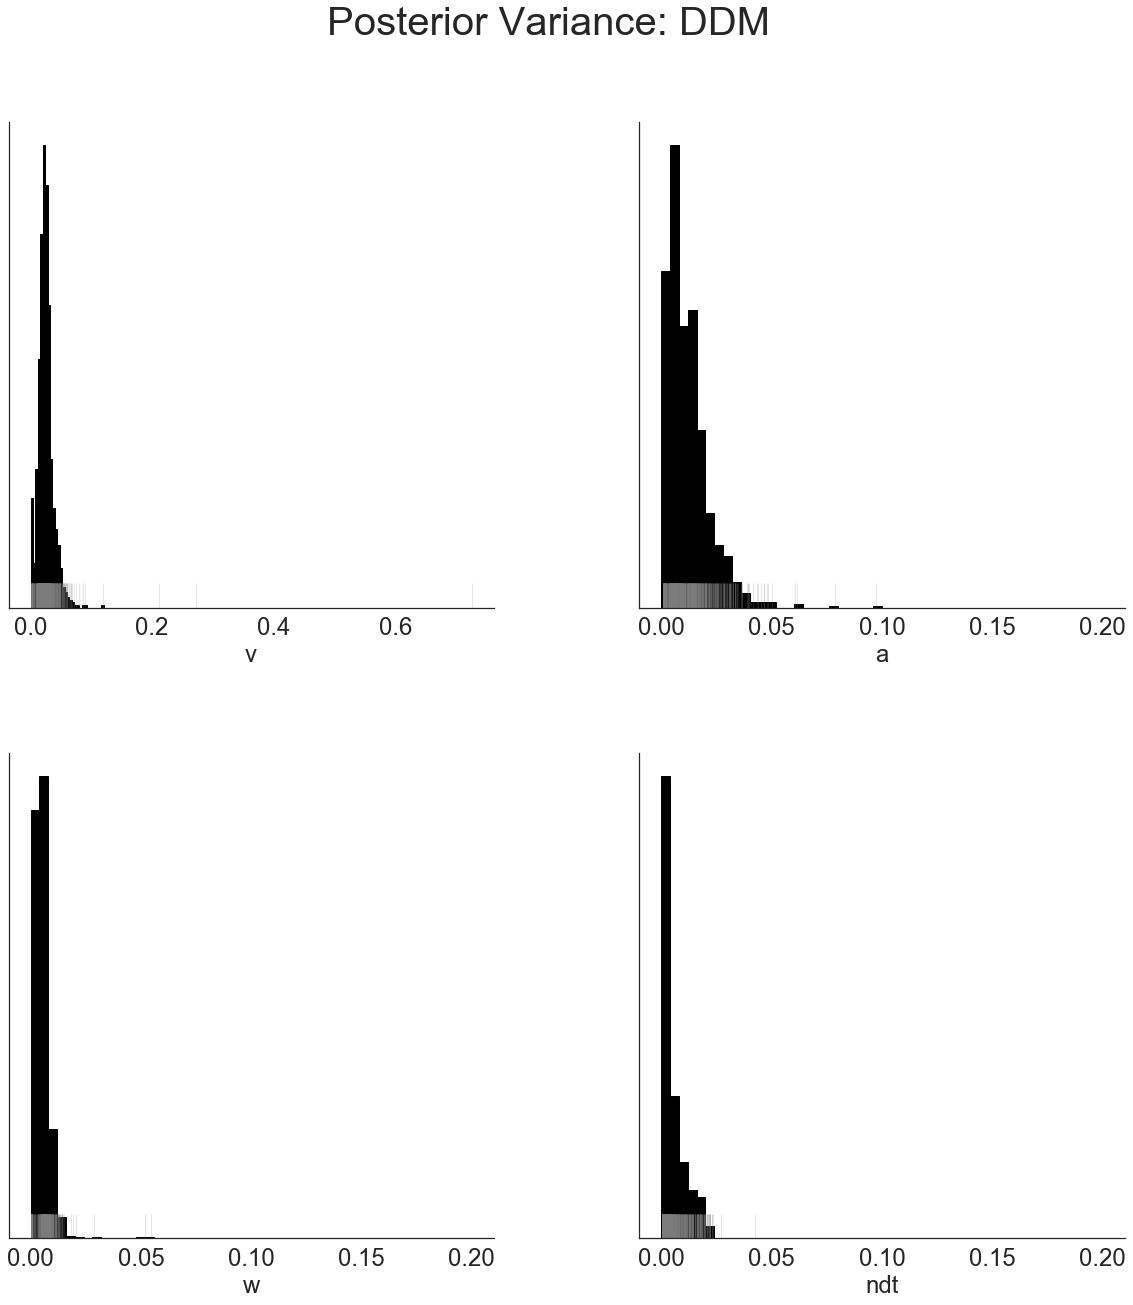

In [23]:
# Posterior variance plot CNN
posterior_variance_plot(ax_titles = ax_titles, 
                        posterior_variances = mcmc_dict['sds'],
                        cols = 2,
                        save = True,
                        data_signature = '_n_' + str(n) + '_' + now,
                        model = model,
                        method = mcmc_dict['method'])

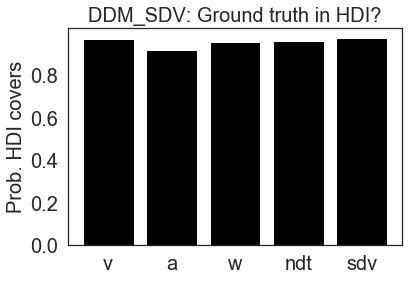

In [209]:
hdi_coverage_plot(ax_titles = ax_titles,
                  model = model,
                  coverage_probabilities = mcmc_dict['p_covered_by_param'],
                  data_signature = '_n_' + str(n) + '_' + now,
                  save = True,
                  method = mcmc_dict['method'])

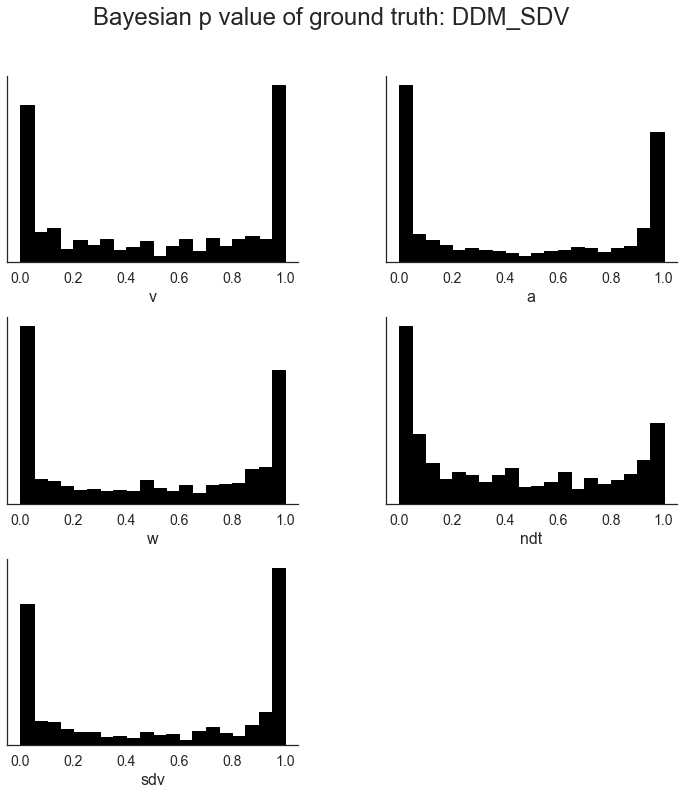

In [206]:
hdi_p_plot(ax_titles = ax_titles,
           p_values = mcmc_dict['gt_cdf_score'],
           cols = 2,
           save = True,
           model = model,
           data_signature = '_n_' + str(n) + '_' + now,
           method = mcmc_dict['method'])

In [26]:
if model == 'angle' or model == 'angle2' or model == 'weibull_cdf':
    # A of T rmse distances plotted
    plt.scatter(mcmc_dict['euc_dist_means_gt'], mcmc_dict['euc_dist_means_gt'], 
                c = mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, 1],
                cmap = 'Greys', 
                alpha = 0.1)
    plt.title('Parameter Distance vs. b(t) RMSE')
    plt.colorbar()
    plt.show()

In [228]:
mcmc_dict['method']

'mlp'

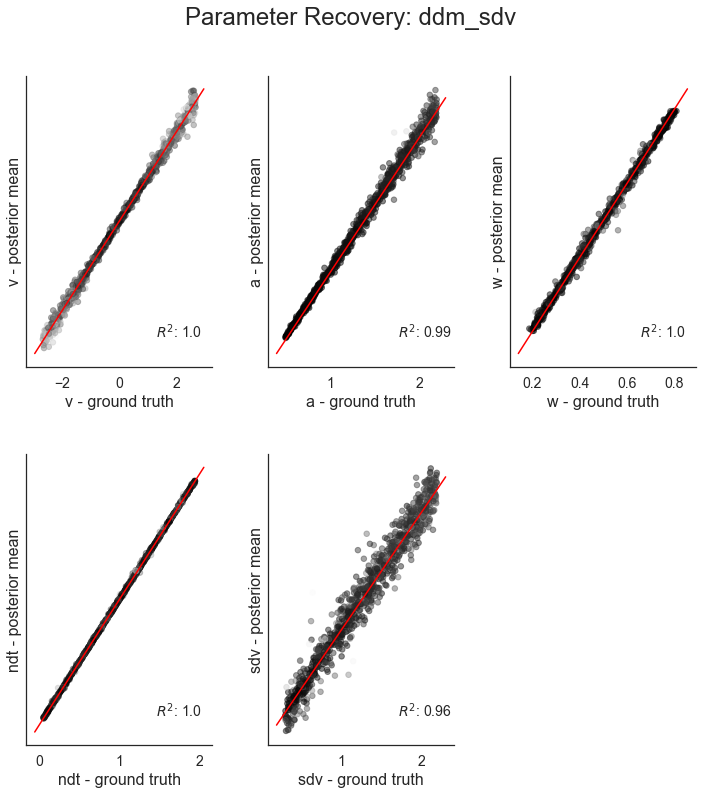

In [210]:
# PARAMETER RECOVERY PLOTS: KDE MLP
parameter_recovery_plot(ax_titles = ax_titles,
                        title = 'Parameter Recovery: ' + model,
                        ground_truths = mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, :],
                        estimates = mcmc_dict['means'][mcmc_dict['r_hats'] < r_hat_cutoff, :],
                        estimate_variances = mcmc_dict['sds'][mcmc_dict['r_hats'] < r_hat_cutoff, :],
                        r2_vec = mcmc_dict['r2_means'],
                        cols = 3,
                        save = True,
                        machine = 'home',
                        data_signature = '_n_' + str(n) + '_' + now,
                        method = mcmc_dict['method'],
                        model = model)

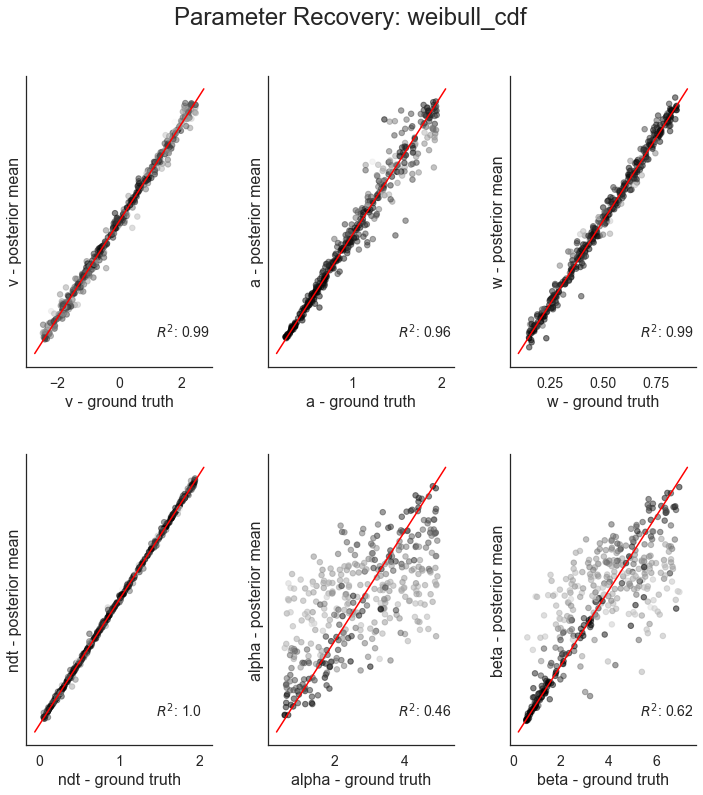

In [74]:
# PARAMETER RECOVERY PLOTS: KDE CNN
parameter_recovery_plot(ax_titles = ax_titles,
                        title = 'Parameter Recovery: ' + model,
                        ground_truths = mcmc_dict['gt'],
                        estimates = mcmc_dict['means'],
                        estimate_variances = mcmc_dict['sds'],
                        r2_vec = mcmc_dict['r2_means'],
                        cols = 3,
                        save = True,
                        machine = 'home',
                        data_signature = '_n_' + str(n) + '_' + now,
                        method = mcmc_dict['method'],
                        model = model)

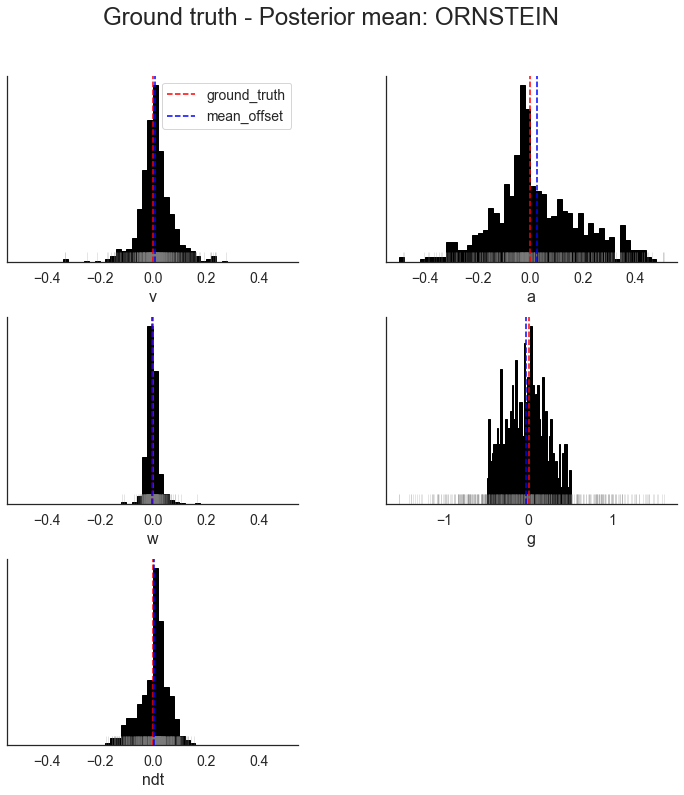

In [197]:
# Parameter recovery hist MLP
parameter_recovery_hist(ax_titles = ax_titles,
                        estimates = mcmc_dict['means'][mcmc_dict['r_hats'] < r_hat_cutoff, :] - mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, :], 
                        cols = 2,
                        save = True,
                        model = model,
                        machine = 'home',
                        posterior_stat = 'mean', # can be 'mean' or 'map'
                        data_signature =  '_n_' + str(n) + '_' + now,
                        method = mcmc_dict['method'])

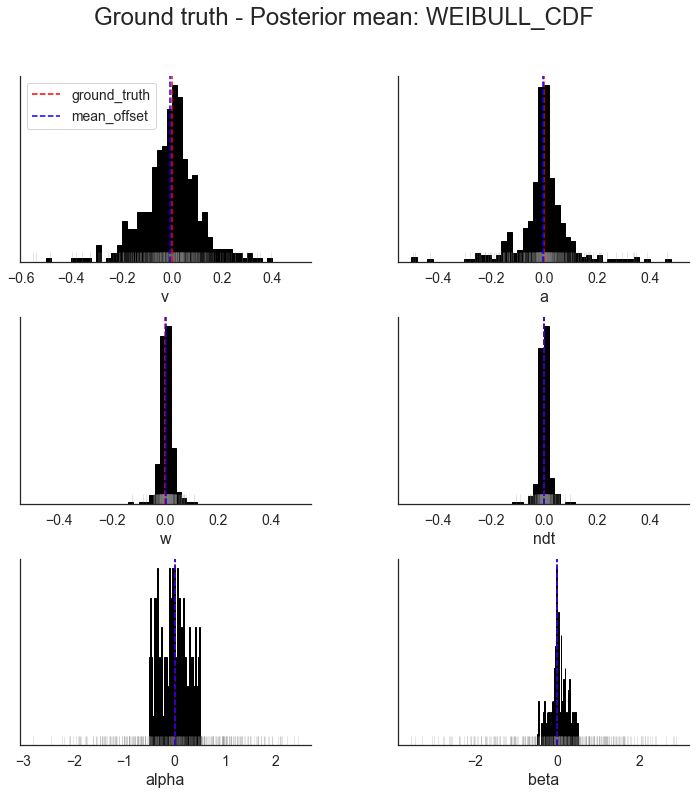

In [76]:
# Parameter recovery hist CNN
parameter_recovery_hist(ax_titles = ax_titles,
                        estimates = mcmc_dict['means'] - mcmc_dict['gt'], 
                        cols = 2,
                        save = True,
                        model = model,
                        machine = 'home',
                        posterior_stat = 'mean', # can be 'mean' or 'map'
                        data_signature =  '_n_' + str(n) + '_' + now,
                        method = mcmc_dict['method'])

In [ ]:
# EUC DIST MEANS GT SORTED ID: MLP
# n_plots = 9
# random_idx = np.random.choice(mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, 0].shape[0], size = n_plots)

idx_vecs = [mcmc_dict['euc_dist_means_gt_sorted_id'][:10], 
          np.arange(int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 - 5), int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 + 5), 1),
          mcmc_dict['euc_dist_means_gt_sorted_id'][-10:],
          np.random.choice(mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, :].shape[0], size = n_plots)]

data_signatures = ['_n_' + str(n) + '_idx_euc_dist_mean_low_' + now,
                  '_n_' + str(n) + '_idx_euc_dist_mean_medium_' + now,
                  '_n_' + str(n) + '_idx_euc_dist_mean_high_' + now,
                  '_n_' + str(n) + '_idx_euc_dist_mean_random_' + now]

cnt = 0
for idx_vec in idx_vecs:
    for idx in idx_vec:
        make_posterior_pair_grid(posterior_samples =  pd.DataFrame(mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < r_hat_cutoff, :, :][idx, :, :],
                                                               columns = ax_titles),
                             gt =  mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, :][idx, :],
                             height = 8,
                             aspect = 1,
                             n_subsample = 100,
                             data_signature = data_signatures[cnt],
                             gt_available = True,
                             save = True,
                             model = model,
                             method = mcmc_dict['method'])
    
    cnt += 1

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e628050>


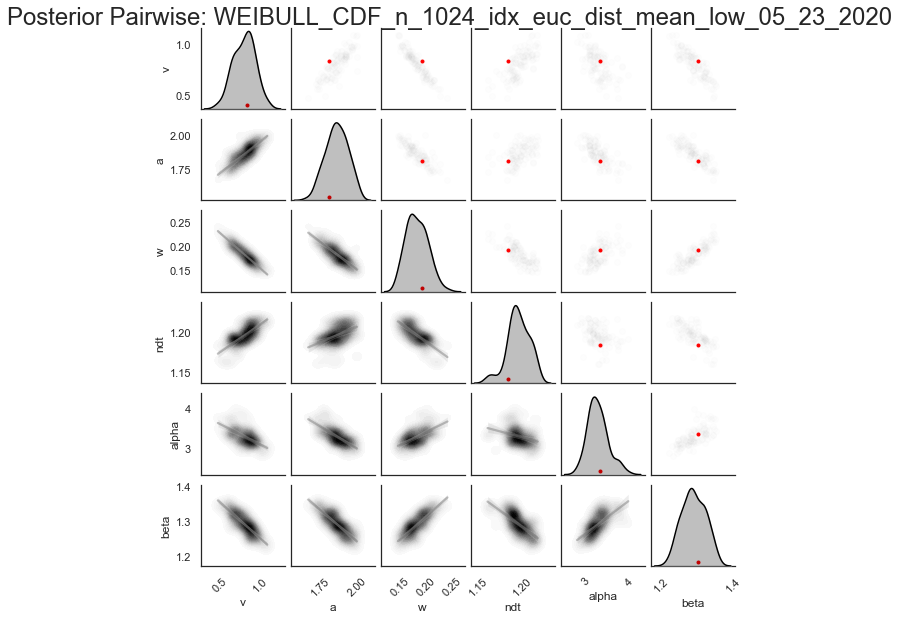

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e453b10>


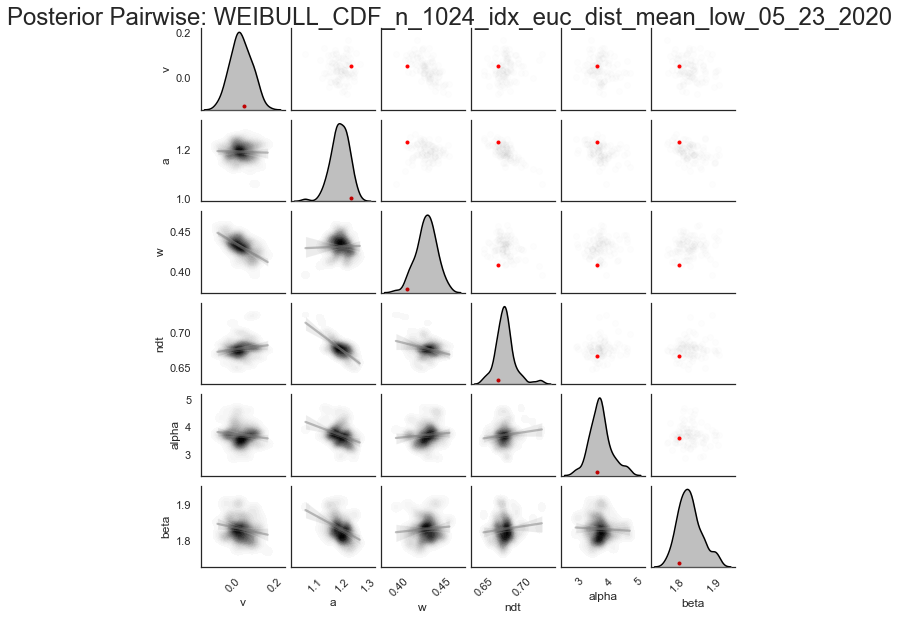

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1bc7c050>


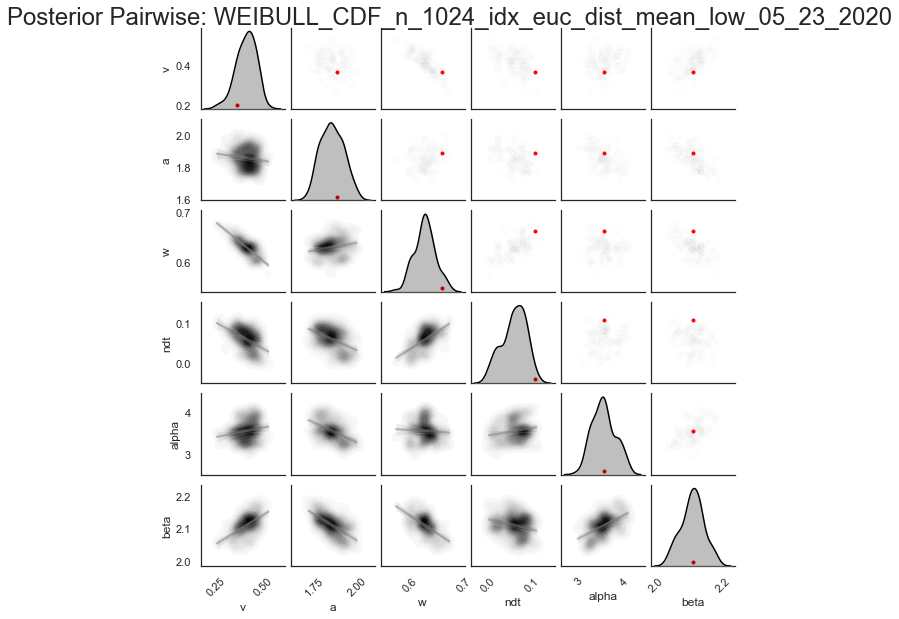

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d8a6b50>


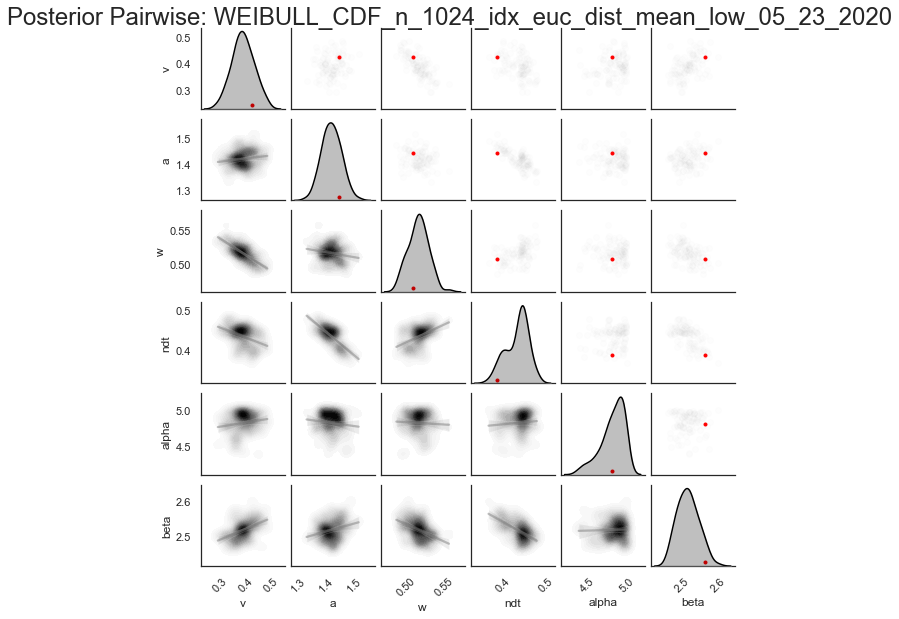

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d658310>


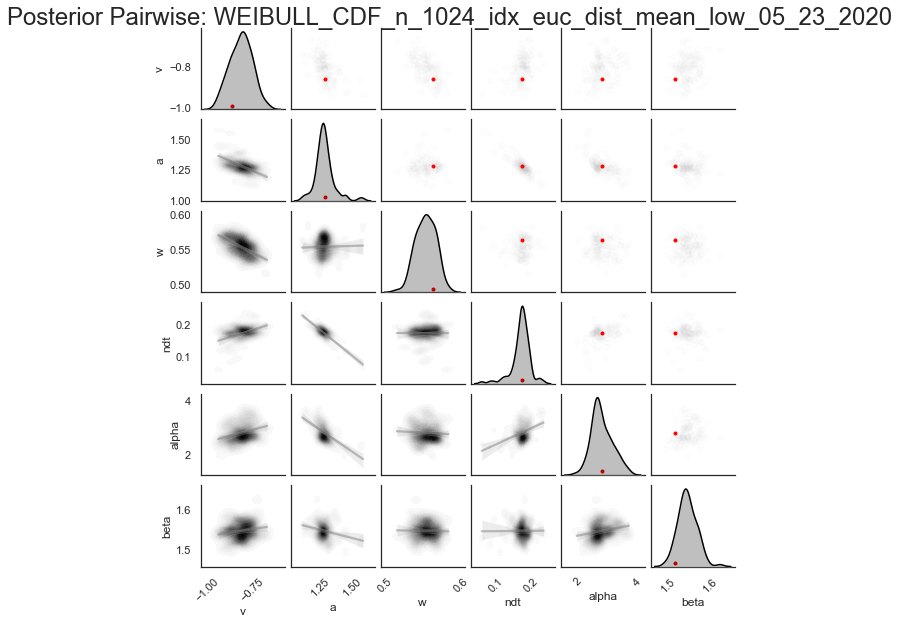

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a27907890>


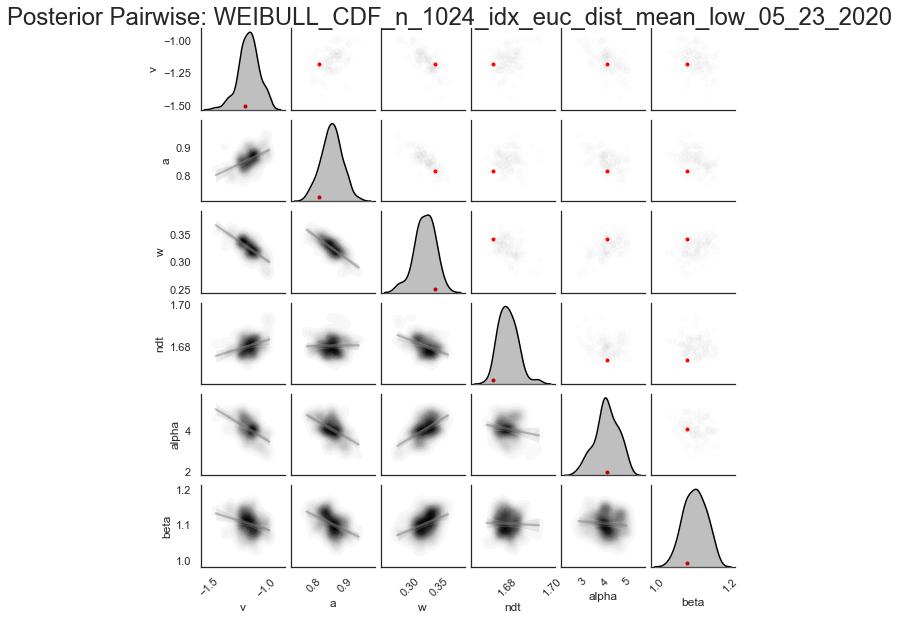

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d6bdd90>


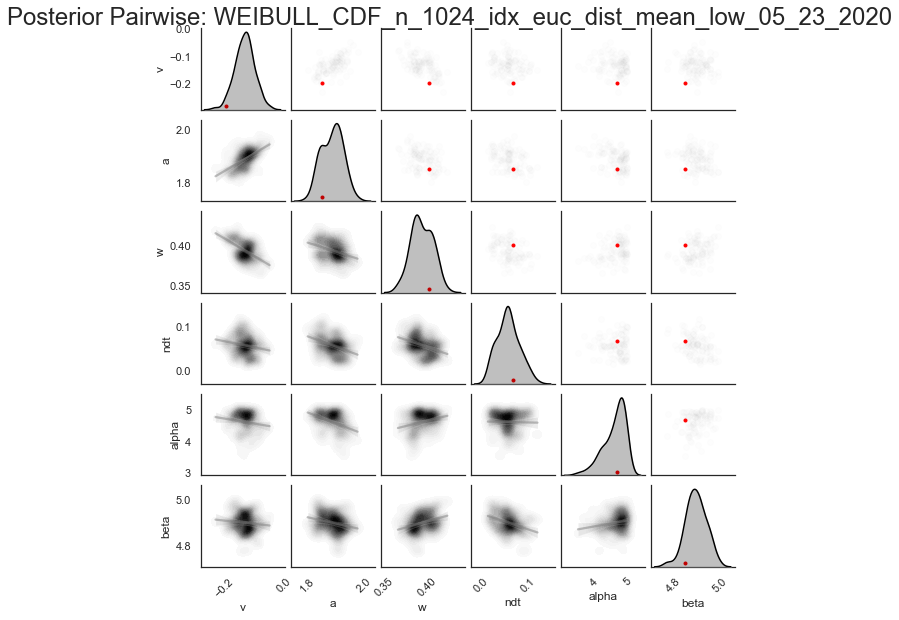

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1e16e890>


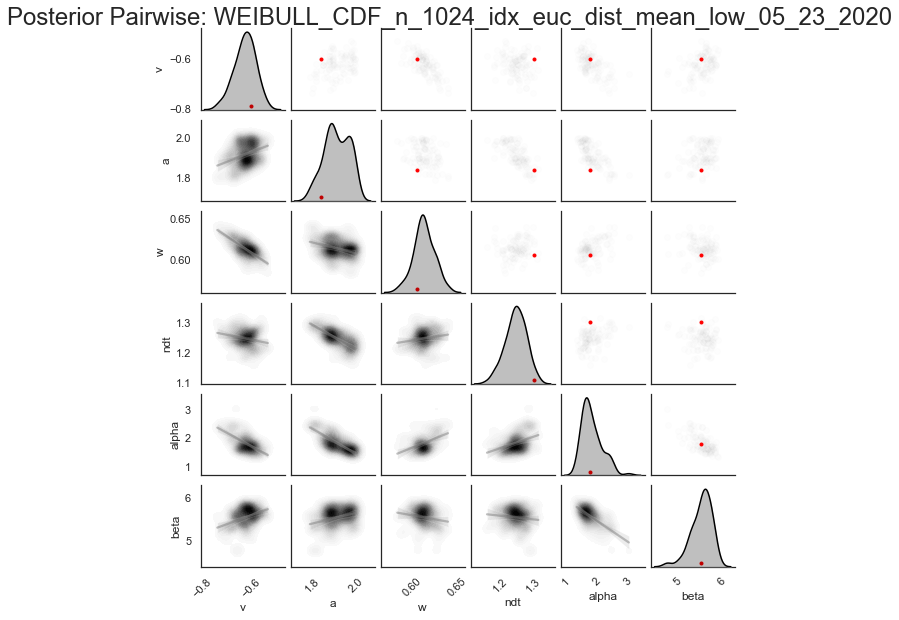

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1cbaaf90>


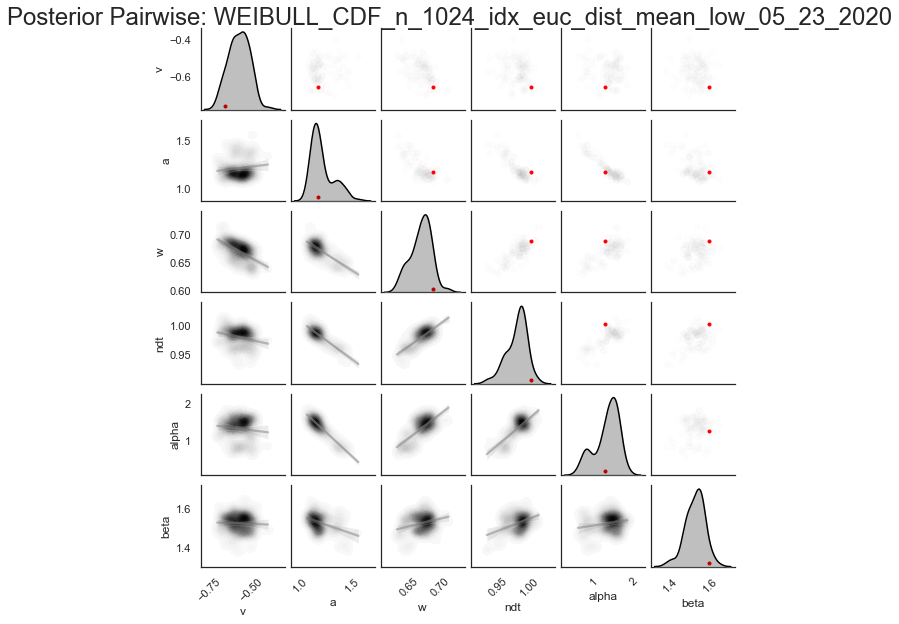

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d89b050>


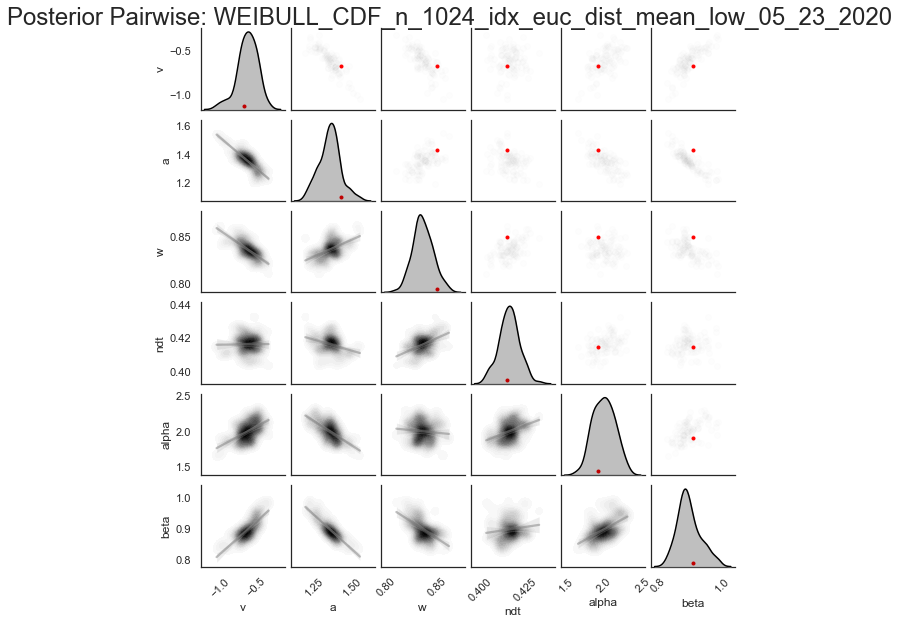

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1be5e510>


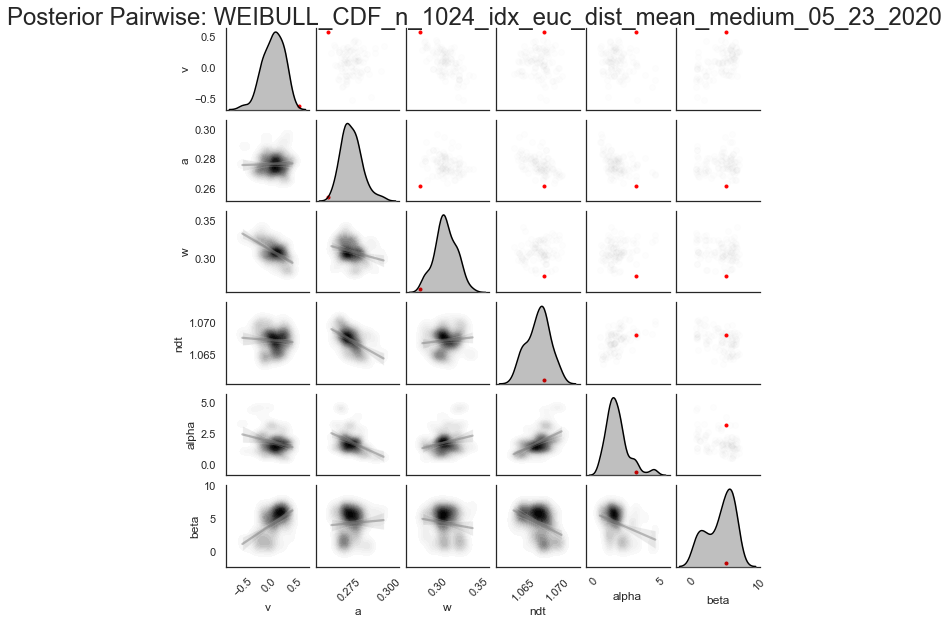

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d453a50>


In [ ]:
# EUC DIST MEANS GT SORTED ID: CNN
idx_vecs = [mcmc_dict['euc_dist_means_gt_sorted_id'][:10], 
          np.arange(int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 - 5), int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 + 5), 1),
          mcmc_dict['euc_dist_means_gt_sorted_id'][-10:],
          np.random.choice(mcmc_dict['gt'].shape[0], size = n_plots)]

data_signatures = ['_n_' + str(n) + '_idx_euc_dist_mean_low_' + now,
                  '_n_' + str(n) + '_idx_euc_dist_mean_medium_' + now,
                  '_n_' + str(n) + '_idx_euc_dist_mean_high_' + now,
                  '_n_' + str(n) + '_idx_euc_dist_mean_random_' + now]

cnt = 0
for idx_vec in idx_vecs:
    for idx in idx_vec:
        make_posterior_pair_grid(posterior_samples =  pd.DataFrame(mcmc_dict['posterior_samples'][idx, :, :],
                                                               columns = ax_titles),
                             gt =  mcmc_dict['gt'][idx, :],
                             height = 8,
                             aspect = 1,
                             n_subsample = 100,
                             data_signature = data_signatures[cnt],
                             gt_available = True,
                             save = True,
                             model = model,
                             method = mcmc_dict['method'])
    
    cnt += 1

In [52]:
mcmc_dict.keys()

dict_keys(['gt', 'posterior_samples', 'timings', 'perplexities', 'importance_weights', 'perplextities', 'sds', 'means', 'gt_cdf_score', 'p_covered_by_param', 'p_covered_all', 'r2_means', 'boundary_rmse', 'boundary_dist_param_euclid', 'euc_dist_means_gt', 'euc_dist_means_gt_sorted_id', 'boundary_rmse_sorted_id', 'method'])

In [ ]:
# MODEL UNCERTAINTY PLOTS: MLP
if model == 'angle' or model == 'weibull_cdf':
    
    idx_vecs = [mcmc_dict['euc_dist_means_gt_sorted_id'][:10], 
                np.arange(int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 - 5), int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 + 5), 1),
                mcmc_dict['euc_dist_means_gt_sorted_id'][-10:]]

    data_signatures = ['_n_' + str(n) + '_idx_' + '_euc_dist_mean_low_',
                       '_n_' + str(n) + '_idx_' + '_euc_dist_mean_medium_',
                       '_n_' + str(n) + '_idx_' + '_euc_dist_mean_high_',]

    for idx_vec in idx_vecs:
        
        boundary_posterior_plot(ax_titles = [str(i) for i in range(9)], 
                                title = 'Model Uncertainty: ',
                                posterior_samples = mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < r_hat_cutoff, :, :][idx_vec, :, :], # dat_total[1][bottom_idx, 5000:, :],
                                ground_truths = mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, :][idx_vec, :], #dat_total[0][bottom_idx, :],
                                cols = 3,
                                model = model, # 'weibull_cdf',
                                data_signature = data_signatures[cnt],
                                n_post_params = 500,
                                samples_by_param = 10,
                                max_t = 10,
                                show = True,
                                save = True,
                                method = mcmc_dict['method'])

maxid 162
passed through
maxid 233
passed through
maxid 168
passed through
maxid 216
passed through
maxid 115
passed through
maxid 46
passed through
maxid 412
passed through
maxid 289
passed through
maxid 143
passed through


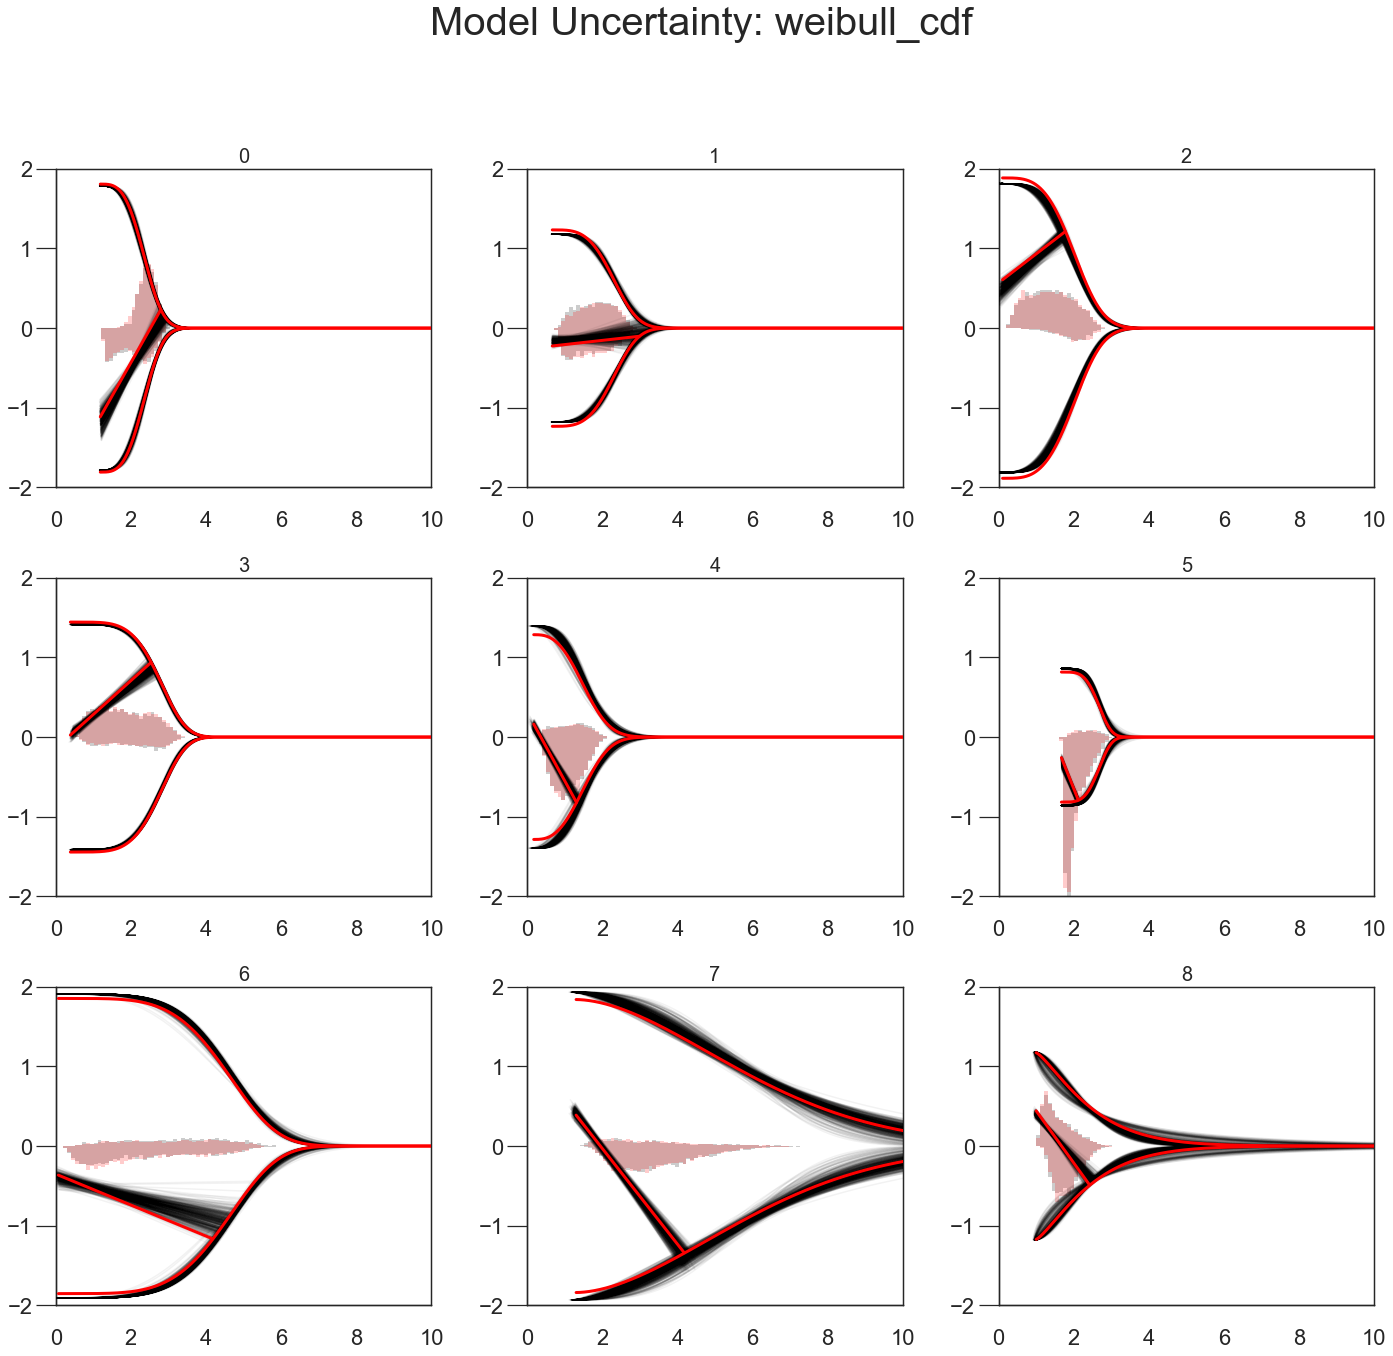

maxid 66
passed through
maxid 628
passed through
maxid 64
passed through
maxid 16
passed through
maxid 27
passed through
maxid 117
passed through
maxid 172
passed through
maxid 146
passed through
maxid 80
passed through


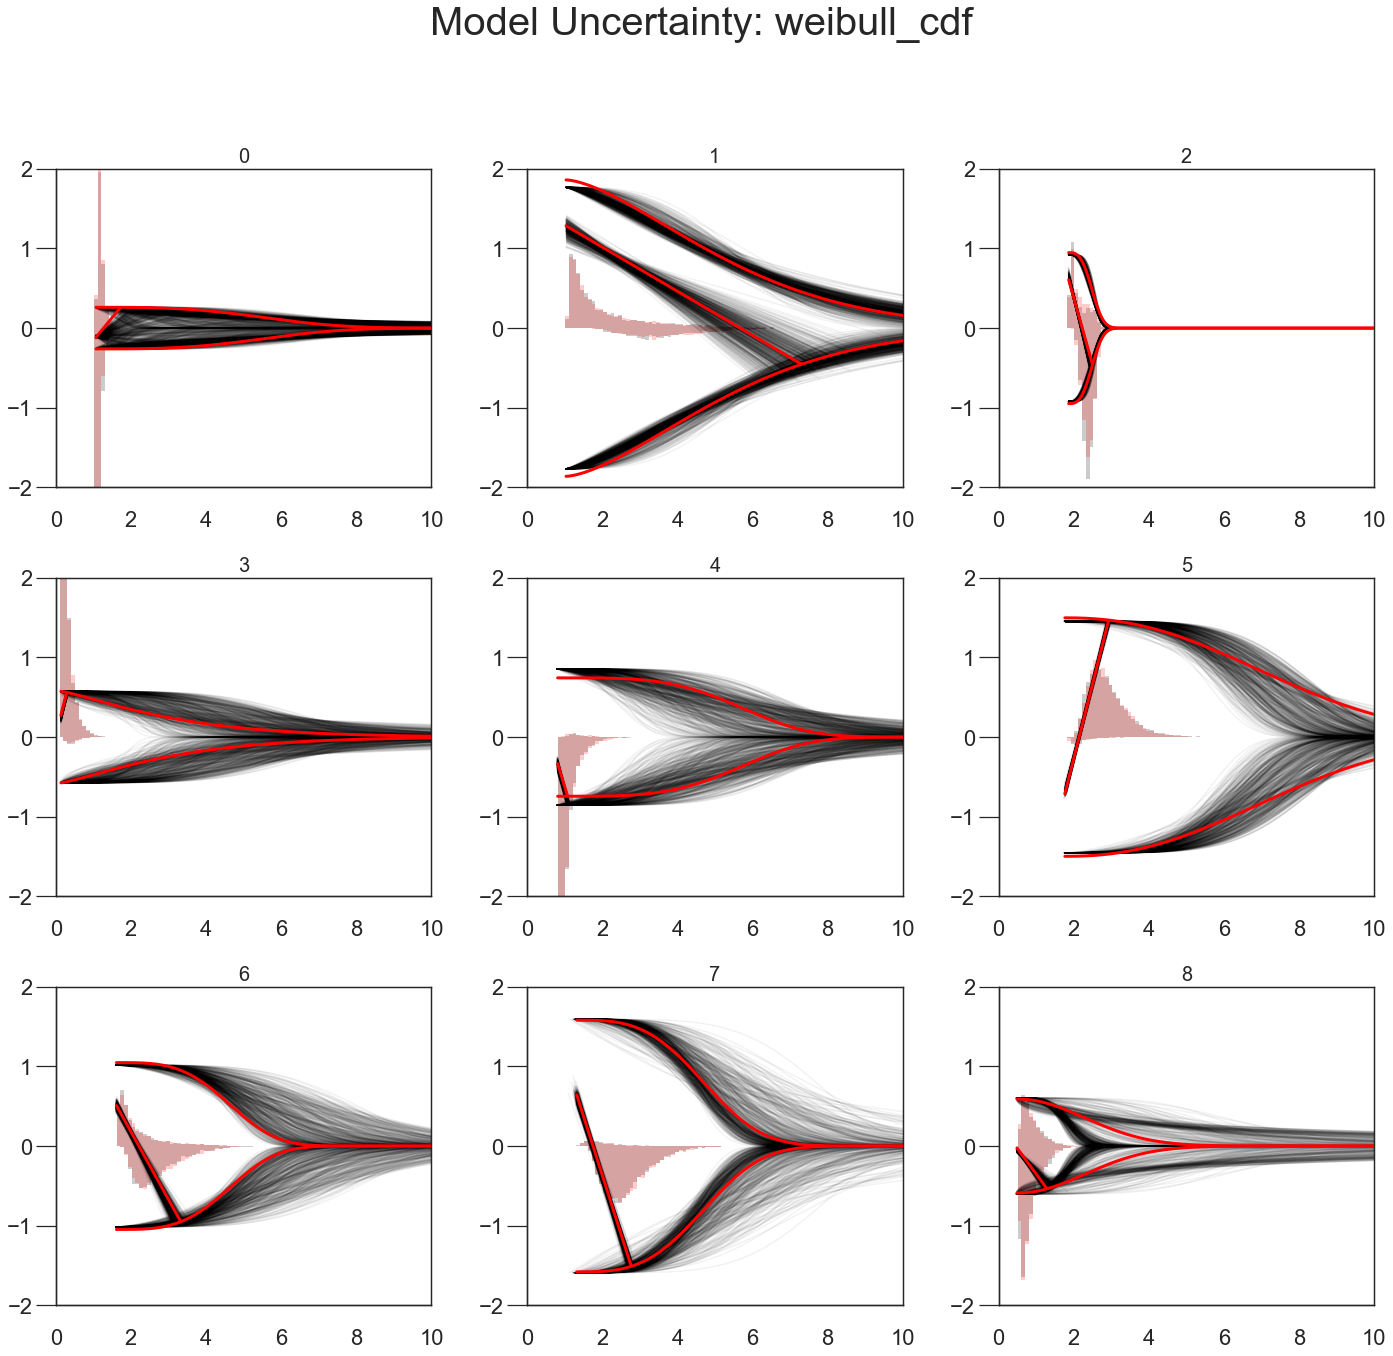

maxid 102
passed through
maxid 22
passed through
maxid 30
passed through
maxid 13
passed through
maxid 53
passed through
maxid 23
passed through
maxid 31
passed through
maxid 55
passed through
maxid 347
passed through


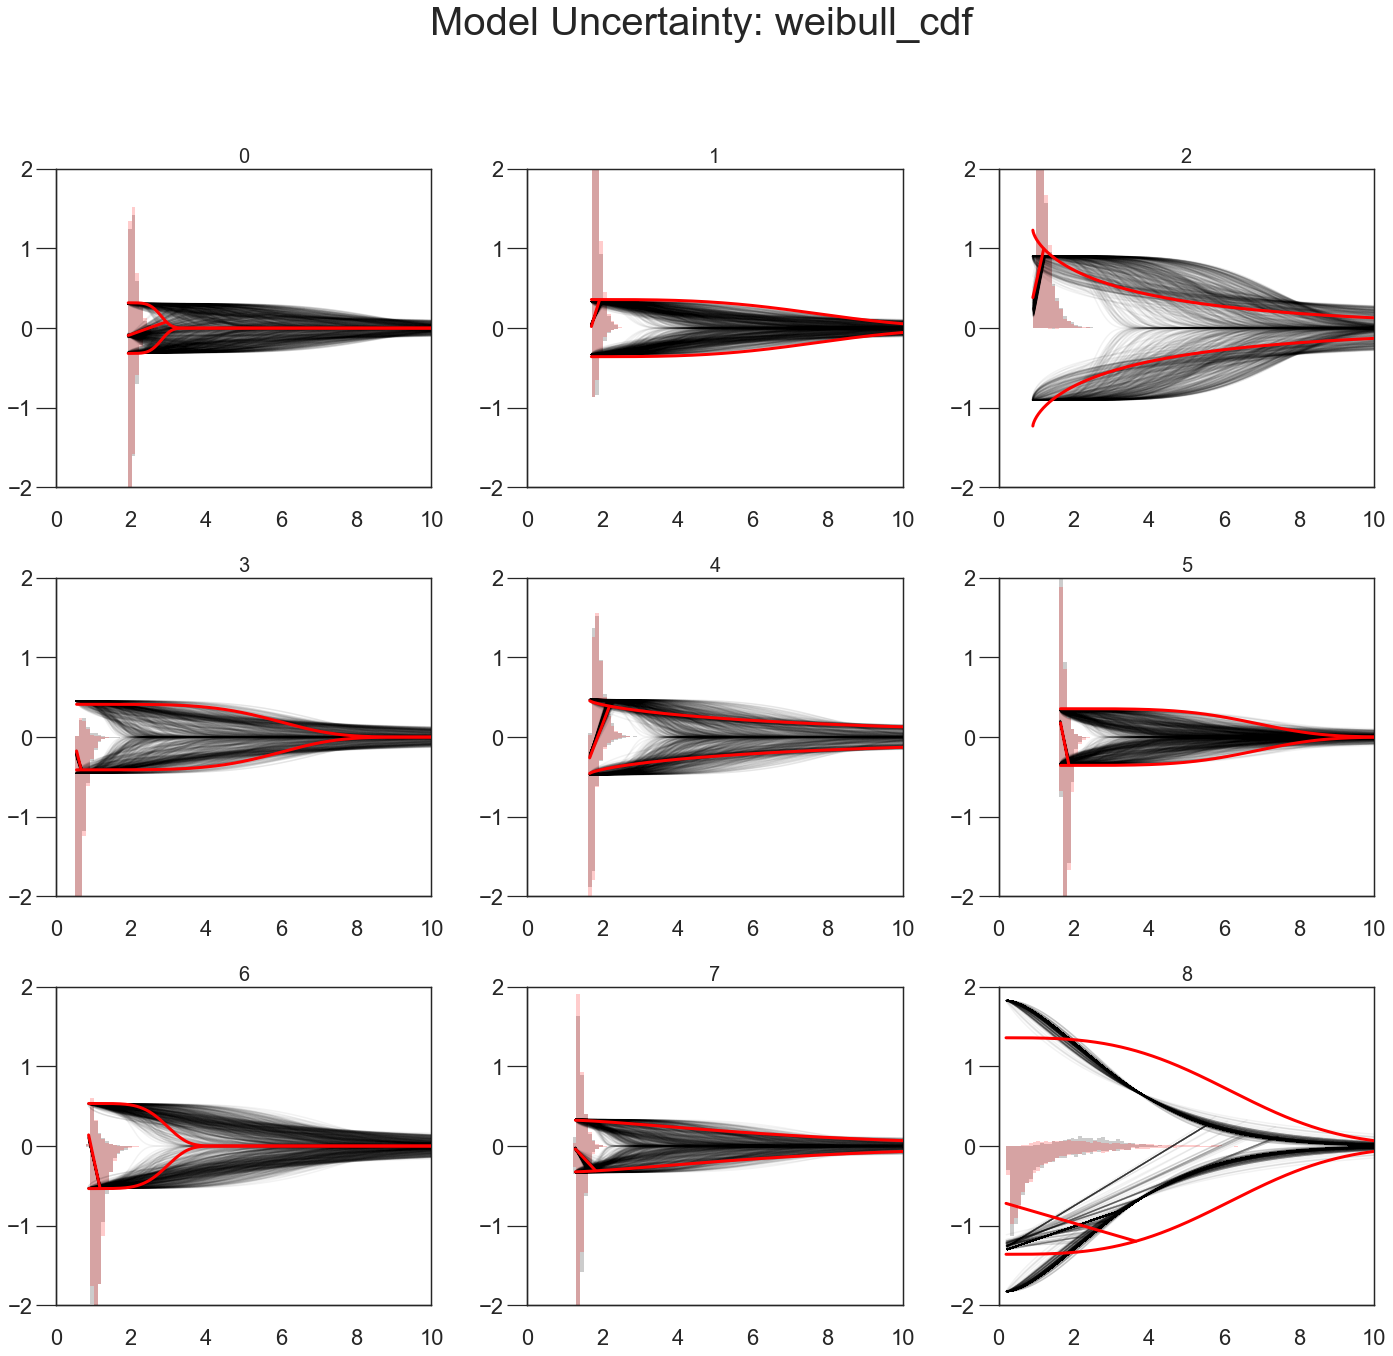

In [7]:
# MODEL UNCERTAINTY PLOTS: CNN
if model == 'angle' or model == 'weibull_cdf':
    
    idx_vecs = [mcmc_dict['euc_dist_means_gt_sorted_id'][:10], 
                np.arange(int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 - 5), int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 + 5), 1),
                mcmc_dict['euc_dist_means_gt_sorted_id'][-10:]]

    data_signatures = ['_n_' + str(n) + '_euc_dist_mean_low_',
                       '_n_' + str(n) + '_euc_dist_mean_medium_',
                       '_n_' + str(n) + '_euc_dist_mean_high_',]
    
    cnt = 0
    for idx_vec in idx_vecs:
        
        boundary_posterior_plot(ax_titles = [str(i) for i in range(9)], 
                                title = 'Model Uncertainty: ',
                                posterior_samples = mcmc_dict['posterior_samples'][idx_vec, :, :], # dat_total[1][bottom_idx, 5000:, :],
                                ground_truths = mcmc_dict['gt'][idx_vec, :], #dat_total[0][bottom_idx, :],
                                cols = 3,
                                model = model, # 'weibull_cdf',
                                data_signature = data_signatures[cnt],
                                n_post_params = 500,
                                samples_by_param = 10,
                                max_t = 10,
                                show = True,
                                save = True,
                                method = mcmc_dict['method'])
        cnt += 1

In [ ]:
# POSTERIOR PREDICTIVE BY EUC DIST MEAN: MLP

idx_vecs = [mcmc_dict['euc_dist_means_gt_sorted_id'][:10], 
          np.arange(int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 - 5), int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 + 5), 1),
          mcmc_dict['euc_dist_means_gt_sorted_id'][-10:]]

data_signatures = ['_n_' + str(n) + '_idx_' + '_euc_dist_mean_low_',
                  '_n_' + str(n) + '_idx_' + '_euc_dist_mean_medium_',
                  '_n_' + str(n) + '_idx_' + '_euc_dist_mean_high_',]

cnt = 0
for idx_vec in idx_vecs:
    posterior_predictive_plot(ax_titles =[str(i) for i in range(9)],
                                  title = 'Posterior Predictive: ',
                                  posterior_samples = mcmc_dict['posterior_samples'][mcmc_dict['r_hats'] < r_hat_cutoff, :, :][idx_vec, :, :], # dat_total[1][bottom_idx, 5000:, :],
                                  ground_truths =  mcmc_dict['gt'][mcmc_dict['r_hats'] < r_hat_cutoff, :][idx_vec, :], #dat_total[0][bottom_idx, :],
                                  cols = 3,
                                  model = model,
                                  data_signature = data_signatures[cnt],
                                  n_post_params = 500,
                                  samples_by_param = 10,
                                  show = True,
                                  method = mcmc_dict['method'])
    cnt += 1

passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through


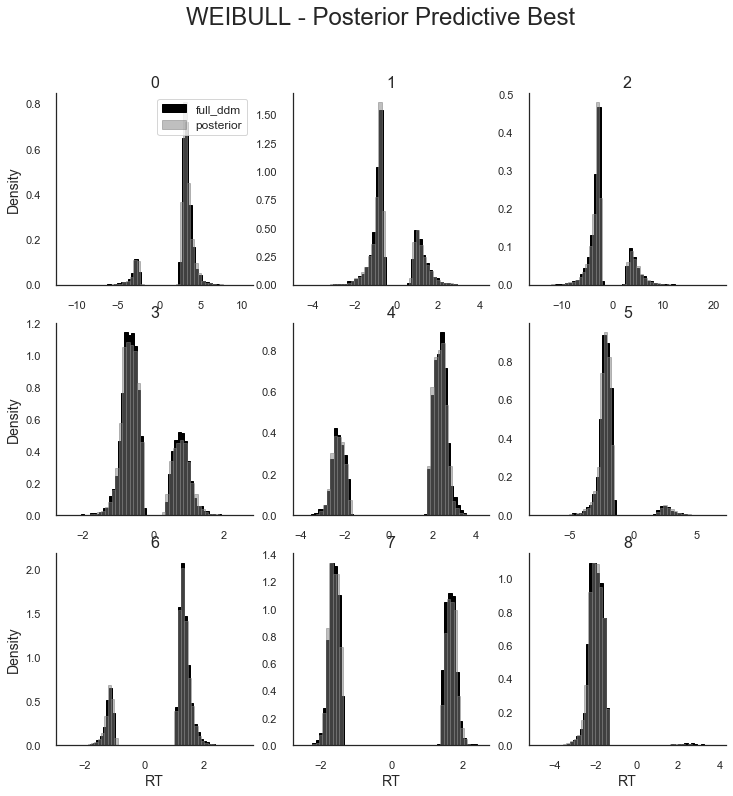

passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through


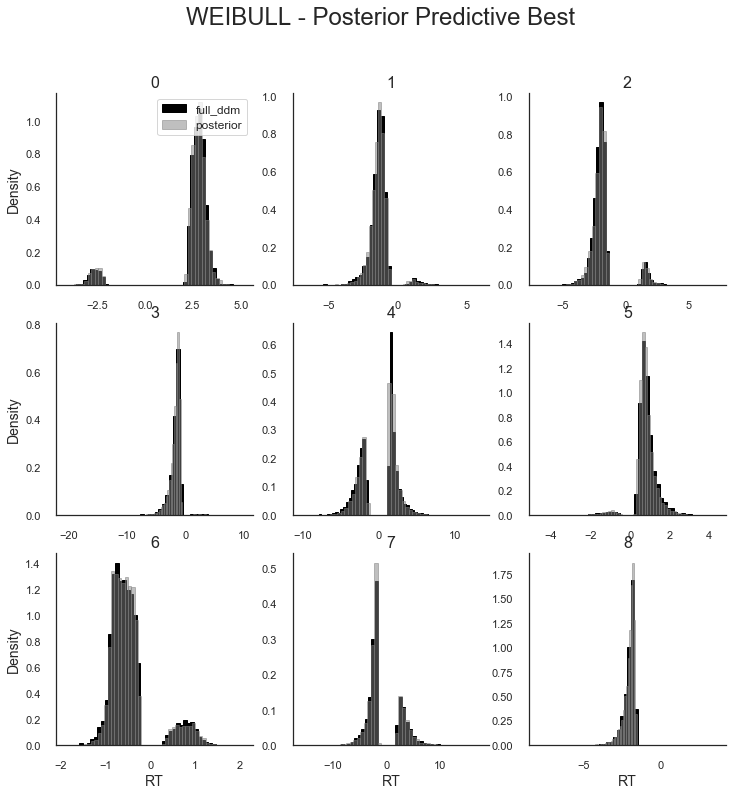

passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through
passed through


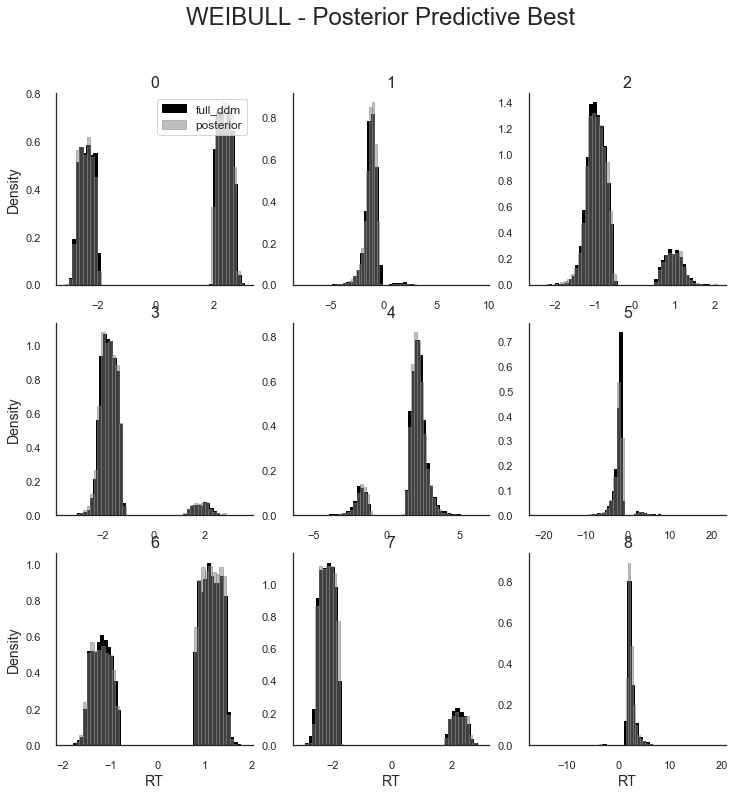

In [64]:
# POSTERIOR PREDICTIVE BY EUC DIST MEAN: CNN

idx_vecs = [mcmc_dict['euc_dist_means_gt_sorted_id'][:10], 
          np.arange(int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 - 5), int(len(mcmc_dict['euc_dist_means_gt_sorted_id']) / 2 + 5), 1),
          mcmc_dict['euc_dist_means_gt_sorted_id'][-10:]]

data_signatures = ['_n_' + str(n) + '_idx_' + '_euc_dist_mean_low_',
                  '_n_' + str(n) + '_idx_' + '_euc_dist_mean_medium_',
                  '_n_' + str(n) + '_idx_' + '_euc_dist_mean_high_',]


cnt = 0
for idx_vec in idx_vecs:
    posterior_predictive_plot(ax_titles =[str(i) for i in range(9)],
                                  title = 'Posterior Predictive: ',
                                  posterior_samples = mcmc_dict['posterior_samples'][idx_vec, :, :], # dat_total[1][bottom_idx, 5000:, :],
                                  ground_truths =  mcmc_dict['gt'][idx_vec, :], #dat_total[0][bottom_idx, :],
                                  cols = 3,
                                  model = model,
                                  data_signature = data_signatures[cnt],
                                  n_post_params = 500,
                                  samples_by_param = 10,
                                  show = True,
                                  method = mcmc_dict['method'])
    cnt += 1

In [ ]:
# UNUSED GRAPHS 


# def trace_plots(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
#                 param_lims = [(-2, 2), (0.5, 2), (0.3,0.7), (0.0, 1.0), (0.0, 1.4)],
#                 title = 'Trace Plots',
#                 posterior_samples = [0, 0, 0],
#                 ground_truths = [0, 0, 0],
#                 trace_id = 1,
#                 cols = 3):
    
#     T = posterior_samples.shape[1]
#     rows = int(np.ceil(len(ax_titles) / cols))

#     sns.set(style = "white", 
#             palette = "muted", 
#             color_codes = True)

#     fig, ax = plt.subplots(rows, 
#                            cols, 
#                            figsize = (20, 20), 
#                            sharex = False, 
#                            sharey = False)

#     sns.despine(right = True)

#     for i in range(posterior_samples.shape[2]):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         sns.lineplot(data = posterior_samples[trace_id, :, i], 
#                      color = 'black', 
#                      ax = ax[row_tmp, col_tmp])
#         ax[row_tmp, col_tmp].axhline(y = ground_truths[trace_id, i], color = 'red')
#         ax[row_tmp, col_tmp].set_ylim(param_lims[i])
#         ax[row_tmp, col_tmp].set_title(ax_titles[i], fontsize = 24)
#         ax[row_tmp, col_tmp].tick_params(axis = "x", 
#                                          labelsize = 24)
#         ax[row_tmp, col_tmp].tick_params(axis = "y", 
#                                          labelsize = 24)

#     for i in range(posterior_samples.shape[2], rows * cols, 1):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         ax[row_tmp, col_tmp].axis('off')

#     #plt.setp(ax, yticks = [])
#     plt.tight_layout()
    
    
# def correlation_hist_plot(data = [0, 0, 0],
#                           ax_titles = ['v', 'a', 'w', 'ndt', 'angle']): 
    
#     # Plot histograms of correlations between parameters
#     # Get array of correlation matrices for all plots
#     corr_mat_array = np.zeros((data[1].shape[0], data[0].shape[1], data[0].shape[1]))   
#     for i in range(data[1].shape[0]):
#         corr_mat_array[i, :, :] = pd.DataFrame(data[1][i, : ,:], columns = ax_titles).corr()

#     grid_size = corr_mat_array.shape[2] - 1

#     fig, ax = plt.subplots(grid_size, grid_size, 
#                            figsize = (20, 20), 
#                            sharex = True, 
#                            sharey = True)

#     fig.suptitle('Posterior Correlations Between Parameters', fontsize = 40)
#     grayscale_map = plt.get_cmap('YlGn')

#     normalized_params = np.zeros(data[0].shape)
#     for i in range(corr_mat_array.shape[1]):
#         normalized_params[:, i] = (data[0][:, i] - np.min(data[0][:, i])) \
#         / (np.max(data[0][:, i]) - np.min(data[0][:, i]))


#     for i in range(grid_size):
#         for j in range(grid_size):
#             if j > i:
#                 ax[i, j].axis('off')
#             else:
#                 sns.distplot(corr_mat_array[:, - (i + 2), - (j + 1)], 
#                              bins = 20,
#                              color = 'black',
#                              norm_hist = True,
#                              kde = True,
#                              rug = True,
#                              rug_kws = {"c": grayscale_map(normalized_params[:,  - (j + 1)]), 
#                                         'alpha': 0.3},
#                              ax = ax[i, j])

#                 if j == 0:
#                     ax[i, j].set_ylabel(ax_titles[- (i + 2)], 
#                                         fontsize = 24);
#                     ax[i, j].tick_params(axis = "y", 
#                                          labelsize = 20)
#                 if i == (grid_size - 1):
#                     ax[i, j].set_xlabel(ax_titles[- (j + 1)], 
#                                         fontsize = 24);
#                     ax[i, j].tick_params(axis = "x", 
#                                          labelsize = 20)

#     ax[i, j].set_yticks(ax[i, j].get_yticks()[::2])                
#     #plt.tight_layout()
#     plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    
# def get_posterior_variances(data = [0, 0, 0],
#                             ax_titles = ['v', 'a', 'w', 'ndt']):
    
#     # MLP
#     var_data = np.array(np.zeros((data[0].shape[0], data[0].shape[1])))
    
#     for i in range(data[0].shape[0]):
#         var_data[i, :] = np.diag(pd.DataFrame(data[1][i, : ,:], columns = ax_titles).cov())
#     return var_data

    
# def posterior_variance_comparison_hist(var_data_1 = [],
#                                        var_data_2 = [],
#                                        var_data_1_title = '..',
#                                        var_data_2_title = '..',
#                                        ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
#                                        cols = 3):  

#     rows = int(np.ceil(len(ax_titles) / cols))

#     sns.set(style = "white", 
#             palette = "muted", 
#             color_codes = True)

#     fig, ax = plt.subplots(rows, cols, 
#                            figsize = (20, 20), 
#                            sharex = False, 
#                            sharey = True)
#     fig.suptitle('Posterior variance: ' + var_data_1_title + ' vs. ' + var_data_2_title + ' (Histogram)', 
#                  fontsize = 40)
#     sns.despine(right = True)

#     x_title = '$\ln \sigma^2_{' + var_data_1_title + '} - \ln \sigma^2_{' + var_data_2_title + '}$'

#     for i in range(var_data_1.shape[1]):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)

#         sns.distplot(np.log((var_data_1[:, i])) -  np.log((var_data_2[:, i])), 
#                      bins = 20,
#                      color = 'black',
#                      norm_hist = True,
#                      kde = False,
#                      rug = False,
#                      #rug_kws = {"c": grayscale_map(dat_total[0][:, j]), 'alpha': 0.3},
#                      ax = ax[row_tmp, col_tmp])

#         ax[row_tmp, col_tmp].set_xlabel(x_title, 
#                                         fontsize = 24);
#         ax[row_tmp, col_tmp].tick_params(axis = "x", 
#                                          labelsize = 24)
#         ax[row_tmp, col_tmp].tick_params(axis = "y",
#                                          labelsize = 24)
#         ax[row_tmp, col_tmp].set_title(ax_titles[i], fontsize = 24)

#     for i in range(var_data_1.shape[1], rows * cols, 1):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         ax[row_tmp, col_tmp].axis('off')

#     plt.tight_layout(rect = [0, 0.03, 1, 0.9])
#     #plt.show()
    

# def posterior_variance_comparison_reg(var_data_1 = [],
#                                       var_data_2 = [],
#                                       params = [], # need params here because we used normalize params to color graphs
#                                       var_data_1_title = '..',
#                                       var_data_2_title = '..',
#                                       ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
#                                       cols = 3):  
#     # 
#     rows = int(np.ceil(len(ax_titles) / cols))

#     sns.set(style = "white", 
#             palette = "muted", 
#             color_codes = True)

#     fig, ax = plt.subplots(rows, cols, 
#                            figsize = (20, 20), 
#                            sharex = False, 
#                            sharey = False)

#     fig.suptitle('Posterior variance: ' + var_data_1_title + ' vs. ' + var_data_2_title + ' (Histogram)', 
#                  fontsize = 40)
#     sns.despine(right = True)

#     x_title = '$\ln \sigma^2_{' + var_data_1_title + '} - \ln \sigma^2_{' + var_data_2_title + '}$'

#     # Get normalized parameters for coloring purposes
#     normalized_params = np.zeros(params.shape)
#     for i in range(params.shape[1]):
#         normalized_params[:, i] = (params[:, i] - np.min(params[:, i])) \
#         / (np.max(params[:, i]) - np.min(params[:, i]))

#     for i in range(params.shape[1]):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         sns.regplot(np.log(var_data_1[:, i]), np.log(var_data_2[:, i]),
#                     marker =  '+',
#                     ax = ax[row_tmp, col_tmp],
#                     scatter_kws = {'s': 120, 
#                                    'alpha': 0.5,
#                                    'color': grayscale_map(normalized_params[:, i])},
#                     line_kws = {'color': 'black'})

#         xlabel_tmp = '$ \ln(\sigma^2_{' +  var_data_1_title  + '})$: ' + ax_titles[i]
#         ylabel_tmp = '$ \ln(\sigma^2_{' +  var_data_2_title  + '})$: ' + ax_titles[i]
        
#         ax[row_tmp, col_tmp].set_xlabel(xlabel_tmp, 
#                                         fontsize = 24);
#         ax[row_tmp, col_tmp].set_ylabel(ylabel_tmp, 
#                                         fontsize = 24);
#         ax[row_tmp, col_tmp].tick_params(axis = "x", 
#                                          labelsize = 24)
#         ax[row_tmp, col_tmp].tick_params(axis = "y", 
#                                          labelsize = 24)

#     for i in range(params.shape[1], rows * cols, 1):
#         row_tmp = int(np.floor(i / cols))
#         col_tmp = i - (cols * row_tmp)
#         ax[row_tmp, col_tmp].axis('off')

#     #plt.setp(ax, yticks = [])
#     plt.tight_layout(rect = [0, 0.03, 1, 0.9])
#     #plt.show()


    
# Plot Post
# def corrdot(*args, **kwargs):
#     corr_r = args[0].corr(args[1], 'pearson')
#     corr_text = round(corr_r, 2)
#     ax = plt.gca()
#     ax.set_axis_off()
#     font_size = (abs(corr_r) * 20) + 5
    
#     marker_size = abs(corr_r) * 7000
#     ax.scatter([.5], [.5], 
#                marker_size, 
#                [corr_r], 
#                alpha = 0.6, 
#                marker = 'o',
#                cmap = "coolwarm",
#                vmin = -1, 
#                vmax = 1, 
#                transform = ax.transAxes)
    
#     ax.annotate(corr_text, [.5, .5,],  
#                 xycoords = "axes fraction",
#                 ha = 'center', 
#                 va = 'center', 
#                 fontsize = font_size)

# def corrfunc(x, y, **kws):
#     r, p = stats.pearsonr(x, y)
#     p_stars = ''
#     if p <= 0.05:
#         p_stars = '*'
#     if p <= 0.01:
#         p_stars = '**'
#     if p <= 0.001:
#         p_stars = '***'
#     ax = plt.gca()
#     ax.annotate(p_stars, xy = (0.6, 0.6), xycoords = ax.transAxes,
#                 color = 'black', fontsize = 20)


In [6]:
x = np.random.choice(100, size = 50)

In [7]:
x

array([80,  3, 45,  5, 68, 14, 61, 85, 27, 62, 93, 98, 59, 89,  3, 83, 73,
        4, 88, 31,  6, 79, 81,  2, 80, 45, 67, 98, 67, 25, 58, 81, 21, 49,
       78, 11, 68,  2, 57, 60, 86, 38, 87, 55, 87, 61, 64, 24, 34, 59])

In [8]:
x.sort()

In [2]:
import numpy as np

In [9]:
x

array([ 2,  2,  3,  3,  4,  5,  6, 11, 14, 21, 24, 25, 27, 31, 34, 38, 45,
       45, 49, 55, 57, 58, 59, 59, 60, 61, 61, 62, 64, 67, 67, 68, 68, 73,
       78, 79, 80, 80, 81, 81, 83, 85, 86, 87, 87, 88, 89, 93, 98, 98])

In [10]:
np.arange(0,100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [16]:
a = np.random.choice(10, size = 9)
a_idx = np.argsort(a)

In [17]:
a[a_idx]

array([0, 0, 1, 3, 5, 7, 7, 8, 9])

In [20]:
os.listdir('figures')

['mlp_performance',
 'posterior_covariance',
 '.DS_Store',
 'bg_stn_cnn_importance_weights.png',
 'parameter_recovery',
 'timings_mlp.png',
 'mlp_likelihoods',
 'hdi_coverage',
 'posterior_predictive',
 'hdi_p',
 'cross_method',
 'mlp_manifolds',
 'mlp_manifold_test.png',
 'cnn',
 '.ipynb_checkpoints',
 'posterior_variance',
 'mlp_manifold_ddm_vary_v.png',
 'mlp',
 'navarro']

In [19]:
import os

In [24]:
os.path.exists('data_storage')

True